# Imports

In [344]:
import numpy as np
from numpy import log as ln, exp
from scipy import stats
from scipy.optimize import fsolve
from matplotlib import pyplot as plot
import matplotlib
import os
from matplotlib.patches import Rectangle

matplotlib.rcParams["figure.dpi"] = 300
os.environ["PATH"] += os.pathsep + """/usr/local/texlive/2023/bin/
                                      universal-darwin"""
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rc("font", family="STIXGeneral") 
matplotlib.rc("font", weight="ultralight")

# Calculating free energies and critical concentrations

In [345]:
def dG_from_CMC(m_CMC: float, N: int) -> float:
    """Calculate dG from CMC for given size of an oligomer."""
    
    return -ln(m_CMC**(1-N) / N)


def dg_from_CMC(m_CMC: float, N: int) -> float:
    """Calculate dG per monomer from CMC for given size of an oligomer."""
    
    return dG_from_CMC(m_CMC, N) / N


def dG_from_K(K: float) -> float:
    """Calculate dG from equilibrium constant."""

    return -ln(K)


def K_from_dG(dG: float) -> float:
    """Calculate equilibrium constant from dG."""

    return exp(-dG)

    
def dg_from_K(K: float, N: int) -> float:
    """Calculate dG per monomer from equilibrium constant of N-merization."""

    return dG_from_K(K) / N


def CMC_from_K(K: float, N: int) -> float:
    """Calculate CMC from equilibrium constant of N-merization."""
    
    return (N * K)**(-1/(N-1))


def CMC_from_dG(dG: float, N: int) -> float:
    """Calculate CMC from dG of N-merization."""
    
    return (N * K_from_dG(dG))**(-1/(N-1))


# General CMC ranges.
print("dG trimers",
      round(dG_from_CMC(10*10**(-6), 3)),
      round(dG_from_CMC(100*10**(-6), 3)))
print("dG tetramers",
      round(dG_from_CMC(10*10**(-6), 4)),
      round(dG_from_CMC(100*10**(-6), 4)))
print("dg trimers",
      round(dg_from_CMC(10*10**(-6), 3)),
      round(dg_from_CMC(10*10**(-6), 3) - ln(10*10**(-6))),
      round(dg_from_CMC(100*10**(-6), 3)),
      round(dg_from_CMC(100*10**(-6), 3) - ln(100 * 10**(-6))))
print("dg tetramers",
      round(dg_from_CMC(10*10**(-6), 4)),
      round(dg_from_CMC(10*10**(-6), 4) - ln(10*10**(-6))),
      round(dg_from_CMC(100*10**(-6), 4)),
      round(dg_from_CMC(100*10**(-6), 4) - ln(100 * 10**(-6))))

# Glucagon [Gratzer 1969].
print("glucagon")
K_2 = 1.5 * 10**3
K_3 = 2.5 * 10**6
K_6 = 6 * 10**16
print("CMCs",
      round(CMC_from_K(K_2, 2) * 10**6),
      round(CMC_from_K(K_3, 3) * 10**6),
      round(CMC_from_K(K_6, 6) * 10**6))

# Insulin [Goldman 1974].
print("insulin")
K_12 = 2.22 * 10**5
K_24 = 40
K_46 = 220
K_16 = K_12**3 * K_24 * K_46
dG_hexa, dg_hexa = dG_from_K(K_16), dg_from_K(K_16, 6)
print("dG hexamer", round(dG_hexa))
print("dg hexamer", round(dg_hexa))
print("CMC", round(CMC_from_dG(dG_hexa, 6) * 10**6))

dG trimers -22 -17
dG tetramers -33 -26
dg trimers -7 4 -6 3
dg tetramers -8 3 -7 3
glucagon
CMCs 333 365 308
insulin
dG hexamer -46
dg hexamer -8
CMC 70


# Theoretical plots of regime changes due to CMCs and critical ratios

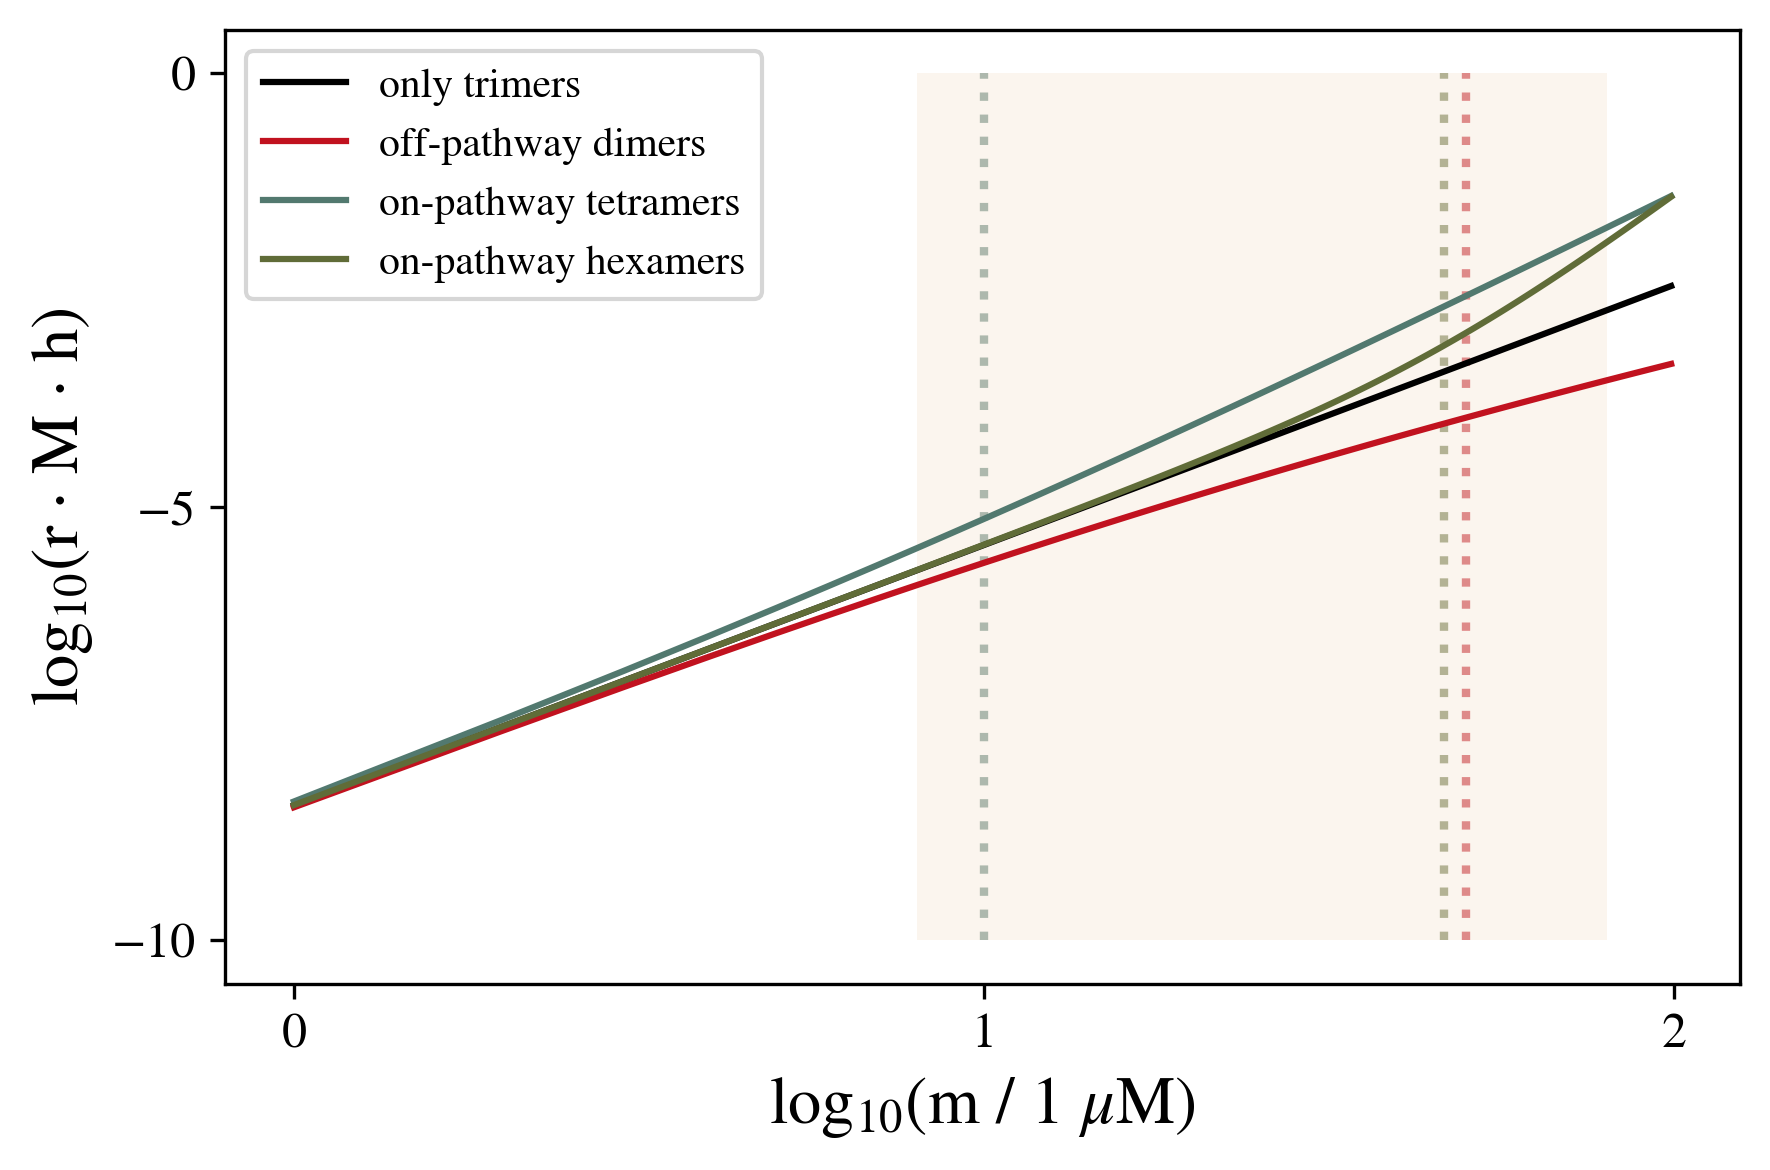

In [346]:
def draw_series(N_off: int, K_off: float,
                N_on_list, K_on_list, k_on_list,
                label: str, color: str):
    """Draw theoretical dependence of primary nucleation rate
       on total monomer concentration.
    
    Parameters
    ----------
        N_off : int or None
            Size of off-pathway oligomers.
            None, if no off-pathway.
        K_off : float or None
            Association equilibrium constant of off-pathway oligomers.
            None, if no off-pathway.
        N_on_list : list
            List of on-pathway oligomer sizes.
        K_on_list : list
            List of on-pathway oligomer association equilibrium constants.
        k_on_list : list
            List of on-pathway oligomer association rate constants.
        label : str
            Name of the series.
        color : str
            Color of the curve.
    """


    def f(m_free: float) -> float:
        """Equation on concentration of free monomers.
        
        Parameters
        ----------
            m_free : float
                Concentration of the free monomers
                to check in the equation.
        
        Returns
        -------
            Precision of the solution.
        """

        return K_off * m_free**N_off + m_free / N_off - m / N_off


    r_list, m_free_list = [], []

    for m in m_arr:
        if N_off is not None:
            m_free = fsolve(f, m / 2)
        else:
            m_free = m
        m_free_list.append(m_free)

        r = 0
        num_on = len(N_on_list)
        for i in range(num_on):
            r += k_on_list[i] * K_on_list[i] * m_free**N_on_list[i]
        
        r_list.append(r)

    ln_m_arr = ln(m_arr * 10**6).flatten() / ln(10)
    ln_r_arr = ln(np.array(r_list) * 60 * 60 / m).flatten() / ln(10)
    
    if N_off is not None:
        CMC_off = CMC_from_K(K_off, N_off) * 10**6
        plot.vlines(x=np.log(CMC_off) / np.log(10), ymin=-10, ymax=0,
                    linestyle="dotted", zorder=-2, linewidth=2,
                    color=color, alpha=0.5)

    if num_on > 1:
        CMC_on = (k_on_list[0] * K_on_list[0] / k_on_list[1] / K_on_list[1])**\
                 (1/(N_on_list[1] - N_on_list[0])) * 10**6
        plot.vlines(x=np.log(CMC_on) / np.log(10), ymin=-10, ymax=0,
                    linestyle="dotted", zorder=-2, linewidth=2,
                    color=color, alpha=0.5)

    plot.plot(ln_m_arr, ln_r_arr, label=label, color=color)

    regr_1 = stats.linregress(ln_m_arr[:10], ln_r_arr[:10])
    regr_2 = stats.linregress(ln_m_arr[50:], ln_r_arr[50:])
    slope_1, slope_2 = regr_1.slope, regr_2.slope
    #print("eff nucl 1", round(get_N_crit(slope_1), 2))
    #print("eff nucl 2", round(get_N_crit(slope_2), 2))


fig, ax = plot.subplots()
m_arr = np.arange(1*10**(-6), 100*10**(-6), 1*10**(-6))    

draw_series(None, None, [3], [10**6], [10**(-4)],
            "only trimers", "black")
draw_series(2, 10**4, [3], [10**6], [10**(-4)],
            "off-pathway dimers", "#c1121f")
draw_series(None, None, [3, 4], [10**6, 10**8], [10**(-4), 10**(-1)],
            "on-pathway tetramers", "#52796f")
draw_series(None, None, [3, 6], [10**6, 10**16], [10**(-4), 10**(-1)],
            "on-pathway hexamers", "#606c38")

ax.add_patch(Rectangle((np.log(8) / np.log(10), -10),
                       (np.log(500) - np.log(50)) / np.log(10), 10,
                        fc="#dda15e", 
                        lw=0, alpha=0.1, zorder=-1))

plot.xlabel(r"log$_{10}$(m / 1 $\mu$M)", fontsize=16)
plot.ylabel(r"log$_{10}$(r $\cdot$ M $\cdot$ h)", fontsize=16)
plot.xticks(fontsize=12)
plot.yticks(fontsize=12)
plot.locator_params(axis="x", nbins=4)
plot.locator_params(axis="y", nbins=4)
plot.legend(loc="upper left")
plot.tight_layout()
plot.savefig("fig/th_m_t_lag.png")
plot.show()

# Kinetics: analytic approximations and lag times

In [361]:
def get_N_tan(slope: float) -> float:
    """Calculate primary nucleus size from slope in tangent lag time definition."""
    
    return -2 * slope + 1


def get_N_elong_cap(slope: float, c: float) -> float:
    return max(-2 * slope + 1 - 1 / c, 1 - slope)


def get_N_inter(s: float, s_dict: dict) -> float:
    for n in set(s_dict.keys()):
        if n > 5:
            continue

        s_n = abs(s_dict[n])
        s = abs(s)
        s_n_next = abs(s_dict[n+1])

        if not (s_n <= s <= s_n_next):
            continue

        w_n = s_n_next - s
        w_n_next = s - s_n

        return (n * w_n + (n+1) * w_n_next) / (w_n + w_n_next)

    print("No appropriate nucleus size found, try other model.")
    return 0


def calculate_series(fig_kin_name=None, fig_slope_name=None,
                     N_th_dict=dict(), regime=None):
    """Calculate and plot kinetic curves for given model parameters, calculate lag times.

    Parameters
    ----------
        fig_kin_name : str or None
            Name of the saved figure with kinetic curves.
        fig_slope_name : str or None
            Name of the saved figure with lag times versus total concentrations.
        N_th_dict : dict
            Sizes of primary nuclei.
        regime : str
            Regime to calculate approximations.
    """

    def calc_lag_time(m: float) -> tuple:
        if K_N == 0 or k_N == 0:
            raise ValueError("Nucleation parameters must be positive.")
        if k_grow == 0:
            raise ValueError("Elongation rate must be positive.")

        # Kinetical parameters of initial aggregation stage
        # assuming free monomer concentration remains almost constant.
        A = N * k_N * K_N * m**N
        B = s * k_surf * K_surf * m**s
        C = k_grow * (m / K_cap)**(1/c)
        D = k_eros
        E = k_frag

        Delta = (B - D)**2 + 4 * C * (E + B / s)
        ev_1 = (B + D + Delta**(1/2)) / 2
        ev_2 = (B + D - Delta**(1/2)) / 2

        if E != 0 or B != 0:
            M = A * s * (C - D * N) / N / (D * B * s - B * C - C * E * s)
            def m_amyl(t: float) -> float:
                """Analytic solution for the aggregated mass if
                   random fragmentation or surface nucleation appear
                   (any aggregated mass-driven secondary events)."""

                return M + ((A + ev_2 * M) * exp(ev_1 * t) - \
                            (A + ev_1 * M) * exp(ev_2 * t)) / (ev_1 - ev_2)
        elif D != B and B != 0 and D != 0:
            def m_amyl(t: float) -> float:
                """Analytic solution for the aggregated mass without random
                   fragmentation but with erosion and surface nucleation."""

                return A * C / N / D / (D - B) * (exp(D * t) - exp(B * t)) + \
                       A / B * (1 - C / N / D) * (exp(B * t) - 1)
        elif D == B and B != 0 and D != 0:
            def m_amyl(t: float) -> float:
                """Analytic solution for the aggregated mass. As previous case,
                   but D == B."""

                return A * C / N / D * t * exp(B * t) + A / B * (1 - C / N / D) * (exp(B * t) - 1)
        elif B == 0 and D != 0:
            def m_amyl(t: float) -> float:
                """Analytic solution for the aggregated mass. If the only secondary
                   event is erosion."""

                return A * (1 - C / N / D) * t + A * C / N / D * (exp(D * t) - 1) / D
        elif D == 0 and B != 0:
            def m_amyl(t: float) -> float:
                """Analytic solution for the aggregated mass. If the only secondary
                   event is surface nucleation."""

                return A / B * (exp(B * t) - 1) + A * C / N / B**2 * (exp(B * t) - 1 - B * t)
        else:
            def m_amyl(t: float) -> float:
                """Analytic solution for the aggregated mass. Without any secondary
                   events."""

                return A * t + A * C / 2 / N * t**2

        def m_amyl_elon(t: float) -> float:
            """Analytic approximation for the aggregated mass
               in the elongation regime."""

            return A * (t + C / (2 * N) * t**2)

        def m_amyl_capp(t: float) -> float:
            """Analytic approximation for the aggregated mass
               in the capping regime."""

            return A * (t + C / (2 * N) * t**2)

        def m_amyl_surf(t: float) -> float:
            """Analytic approximation for the aggregated mass
               in the surface nucleation regime."""

            return A * (t + (B + C / N) / 2 * t**2)

        def m_amyl_frag(t: float) -> float:
            """Analytic approximation for the aggregated mass
               in the random fragmentation regime."""

            #return A / 2 * ((N * k_frag)**(-1) + (m * k_grow * k_frag)**(-1/2)) \
            #             * exp((C * E)**(1/2) * t)
            return A / 2 * ((N * k_frag)**(-1)) * exp((C * E)**(1/2) * t)

        def m_amyl_eros(t: float) -> float:
            """Analytic approximation for the aggregated mass
               in the erosion regime."""

            #return A * ((1 - C / N / D) * t + C / N / D**2 * (exp(D * t) - 1))
            return A * C / N / D**2 * exp(D * t)

        t_arr = np.arange(0, T + T / num_t, T / num_t)
        m_amyl_list, m_amyl_approx_list = [], []

        m_amyl_approx = {
            "elon": m_amyl_elon,
            "capp": m_amyl_capp,
            "surf": m_amyl_surf,
            "frag": m_amyl_frag,
            "eros": m_amyl_eros
        }

        # Find lag times for analytic exact and analytic approximate solution.
        lag_flag, lag_flag_approx = True, True
        for t in t_arr:
            m_amyl_t = m_amyl(t)
            m_amyl_list.append(m_amyl_t)

            if lag_flag and m_amyl_t > alpha * m:
                t_lag = t
                lag_flag = False

            m_amyl_approx_t = m_amyl_approx[regime](t)
            m_amyl_approx_list.append(m_amyl_approx_t)

            if lag_flag_approx and m_amyl_approx_t > alpha * m:
                t_lag_approx = t
                lag_flag_approx = False

        if plot_kinetics:
            ax_dict[N].set_title("N = " + str(N), fontsize=12)
            ax_dict[N].plot(t_arr / 60 / 60, np.array(m_amyl_approx_list) / m * 100,
                            linewidth=1, color="black", linestyle="--", zorder=1)#color="#606c38")
            if N == 6:
                label = str(round(m * 10**6)) + r" $\mu$M"
            else:
                label = None
            ax_dict[N].plot(t_arr / 60 / 60, np.array(m_amyl_list) / m * 100,
                            linewidth=4, color=m_color_dict[m],
                            label=label, zorder=0)

        return t_lag, t_lag_approx

    def quad_eq_sol(m: float) -> float:
        A = N * k_N * K_N * m**N
        B = s * k_surf * K_surf * m**s
        C = k_grow * (m / K_cap)**(1/c)
        return (-1 + (1 + 2 * (B + C / N) * alpha * m / A)**(1/2)) / (B + C / N)

    if plot_kinetics:
        # Create axes for nuclei sizes from 1 to 6.
        fig, ((ax_1, ax_2), (ax_3, ax_4), (ax_5, ax_6)) = plot.subplots(3, 2)
        ax_dict = {
            1: ax_1,
            2: ax_2,
            3: ax_3,
            4: ax_4,
            5: ax_5,
            6: ax_6
        }
        #fig, ax_2 = plot.subplots()

    for N in N_list:
        K_N = 10**(4*(N-1))

        # Calculate theoretical lag times in quadratic expansion.
        th_m_list, th_t_list = [], []
        for m in np.arange(10*10**(-6), 1000*10**(-6), 10**(-6)):
            th_m_list.append(m)
            th_t_list.append(quad_eq_sol(m))

        ln_th_m_list = ln(np.array(th_m_list) * 10**6) / ln(10)  # in μM
        ln_th_t_list = ln(np.array(th_t_list) / 60 / 60) / ln(10)  # in hours
        regr = stats.linregress(ln_th_m_list, ln_th_t_list)
        print()
        print("R^2", round(regr.rvalue**2, 2))
        slope, intercept = regr.slope, regr.intercept

        #plot.plot(ln_th_m_list, ln_th_t_list, color="black")
        #plot.tight_layout()
        #plot.show()

        m_list = [100*10**(-6), 150*10**(-6), 200*10**(-6), 250*10**(-6), 300*10**(-6)]
        t_lag_list, t_lag_approx_list = [], []
        for m in m_list:
            t_lag, t_lag_approx = calc_lag_time(m)
            t_lag_list.append(t_lag)
            t_lag_approx_list.append(t_lag_approx)

        if plot_kinetics:
            if N >= 5:
                ax_dict[N].tick_params(axis="x", which="both", labelsize=12)
                ax_dict[N].locator_params(axis="x", tight=True, nbins=4)
                #ax_dict[N].set_xlabel("Time, hours", fontsize=12)
            if N < 5:
                ax_dict[N].set_xticklabels(())
            if N == 3:
                ax_dict[N].set_ylabel("Conversion, %", fontsize=12)
            if N % 2 == 0:
                ax_dict[N].set_yticklabels(())
            ax_dict[N].tick_params(axis="y", which="both", labelsize=12)
            ax_dict[N].locator_params(axis="y", tight=True, nbins=2)
            ax_dict[N].set_xlim(xmin=0, xmax=max(t_lag_list) / 60 / 60)
            ax_dict[N].set_ylim(ymin=0, ymax=alpha * 100)
            #plot.hlines(y=alpha * 100, xmin=0, xmax=T / 60 / 60, color="black", alpha=0.5)
            #if N == 2:
                #ax_dict[N].set_xlabel("Time, hours")
                #ax_dict[N].set_ylabel("Conversion, %")

        print("concentrations", m_list)
        print("lag times", t_lag_list)

        ln_m_arr = ln(np.array(m_list) * 10**6) / ln(10)
        ln_t_lag_arr = ln(np.array(t_lag_list) / 60 / 60) / ln(10)
        ln_t_lag_approx_arr = ln(np.array(t_lag_approx_list) / 60 / 60) / ln(10)

        if plot_slopes:
            #plot.scatter(ln_m_arr, ln_t_lag_approx_arr,
            #             color="none", edgecolor="black", linewidth=2, s=128)
            plot.scatter(ln_m_arr, ln_t_lag_arr,
                         color="none", edgecolor=N_color_list[N-1],
                         linewidth=2, s=128, label="N = " + str(N))
            plot.xticks(fontsize=16)
            plot.yticks(fontsize=16)
            plot.xlabel(r"$log_{10}(m\ /\ 1\ \mu M)$", fontsize=16)
            plot.ylabel(r"$log_{10}(t_{lag}\ /\ 1\ h)$", fontsize=16)

        regr = stats.linregress(ln_m_arr, ln_t_lag_arr)
        print("R^2 precise", round(regr.rvalue**2, 2))
        slope, intercept = regr.slope, regr.intercept
        if plot_slopes:
            plot.plot(ln_m_arr, ln_m_arr * slope + intercept, color=N_color_list[N-1])
        N_th_dict[N] = get_N_elong_cap(slope, 1)

        print("N", N)
        print("slope", round(slope, 2))
        print("N_th", round(N_th_dict[N], 2))
        print("lag times precise (h)", np.array(t_lag_list) / 60 / 60)
        print("lag time approx (h)", np.array(t_lag_approx_list) / 60 / 60)

    if plot_kinetics:
        #plot.locator_params(nbins=4)
        fig.supxlabel("Time, hours", fontsize=12, y=0.05)
        plot.tight_layout()
        plot.legend(loc="lower right", ncol=5, bbox_to_anchor=(1, -1.5))
        plot.savefig("fig/" + fig_kin_name + ".png")
        plot.show()

    if plot_slopes:
        plot.legend()
        plot.tight_layout()
        plot.savefig("fig/" + fig_slope_name + ".png")
        plot.show()


# True to plot lag times versus concentrations in double log coordinates.
plot_slopes = False
# True to plot kinetical curves.
plot_kinetics = True
# Number of timestamps.
num_t = 10000

# Sizes of primary nuclei, calculations will be performed for each one.
#N_list = [2]  # To plot only slopes.
N_list = [1, 2, 3, 4, 5, 6]  # For kinetical plotting.

# Corresponding colors to distinguish series with different nuclei sizes.
#N_color_list = ["#52b788", "#40916c", "#2d6a4f", "#1b4332", "#081c15"]
N_color_list = ["#d9ed92", "#b5e48c", "#76c893", "#34a0a4", "#1a759f", "#184e77"]

# Colors for concentrations.
m_color_dict = {
    100*10**(-6): "#ffb3c1",#"#ad2831",
    150*10**(-6): "#ff8fa3",#"#800e13",
    200*10**(-6): "#ff758f",#"#640d14",
    250*10**(-6): "#ff4d6d",#"#38040e",
    300*10**(-6): "#c9184a"#"#250902"
}

# Conversion threshold to define the lag time.
alpha = 0.01

# Size of the secondary nuclei.
s = 2

# Conversion rate constant of transient N-mers [1 / s].
k_N = 10**(-9)

# Conversion rate constant of secondary oligomers [1 / s].
k_surf = 10**(-4)

# Association equilibrium constant of secondary oligomers [1 / M^s].
K_surf = 10**3

# Fibril elongation rate constant [1 / M / s].
k_grow = 10**1

# Maximal time [s].
T = 60 * 60 * 40

# Elongation regime


R^2 1.0
concentrations [9.999999999999999e-05, 0.00015, 0.00019999999999999998, 0.00025, 0.0003]
lag times [140428.80000000002, 114811.2, 99504.0, 89049.6, 81331.2]
R^2 precise 1.0
N 1
slope -0.5
N_th 1.5
lag times precise (h) [39.008 31.892 27.64  24.736 22.592]
lag time approx (h) [39.008 31.892 27.64  24.736 22.592]

R^2 1.0
concentrations [9.999999999999999e-05, 0.00015, 0.00019999999999999998, 0.00025, 0.0003]
lag times [139449.6, 92966.40000000001, 69724.8, 55785.6, 46483.200000000004]
R^2 precise 1.0
N 2
slope -1.0
N_th 2.0
lag times precise (h) [38.736 25.824 19.368 15.496 12.912]
lag time approx (h) [38.736 25.824 19.368 15.496 12.912]

R^2 1.0
concentrations [9.999999999999999e-05, 0.00015, 0.00019999999999999998, 0.00025, 0.0003]
lag times [138456.0, 75009.6, 48528.0, 34603.200000000004, 26236.8]
R^2 precise 1.0
N 3
slope -1.51
N_th 3.03
lag times precise (h) [38.46  20.836 13.48   9.612  7.288]
lag time approx (h) [38.46  20.836 13.48   9.612  7.288]

R^2 1.0
concentration

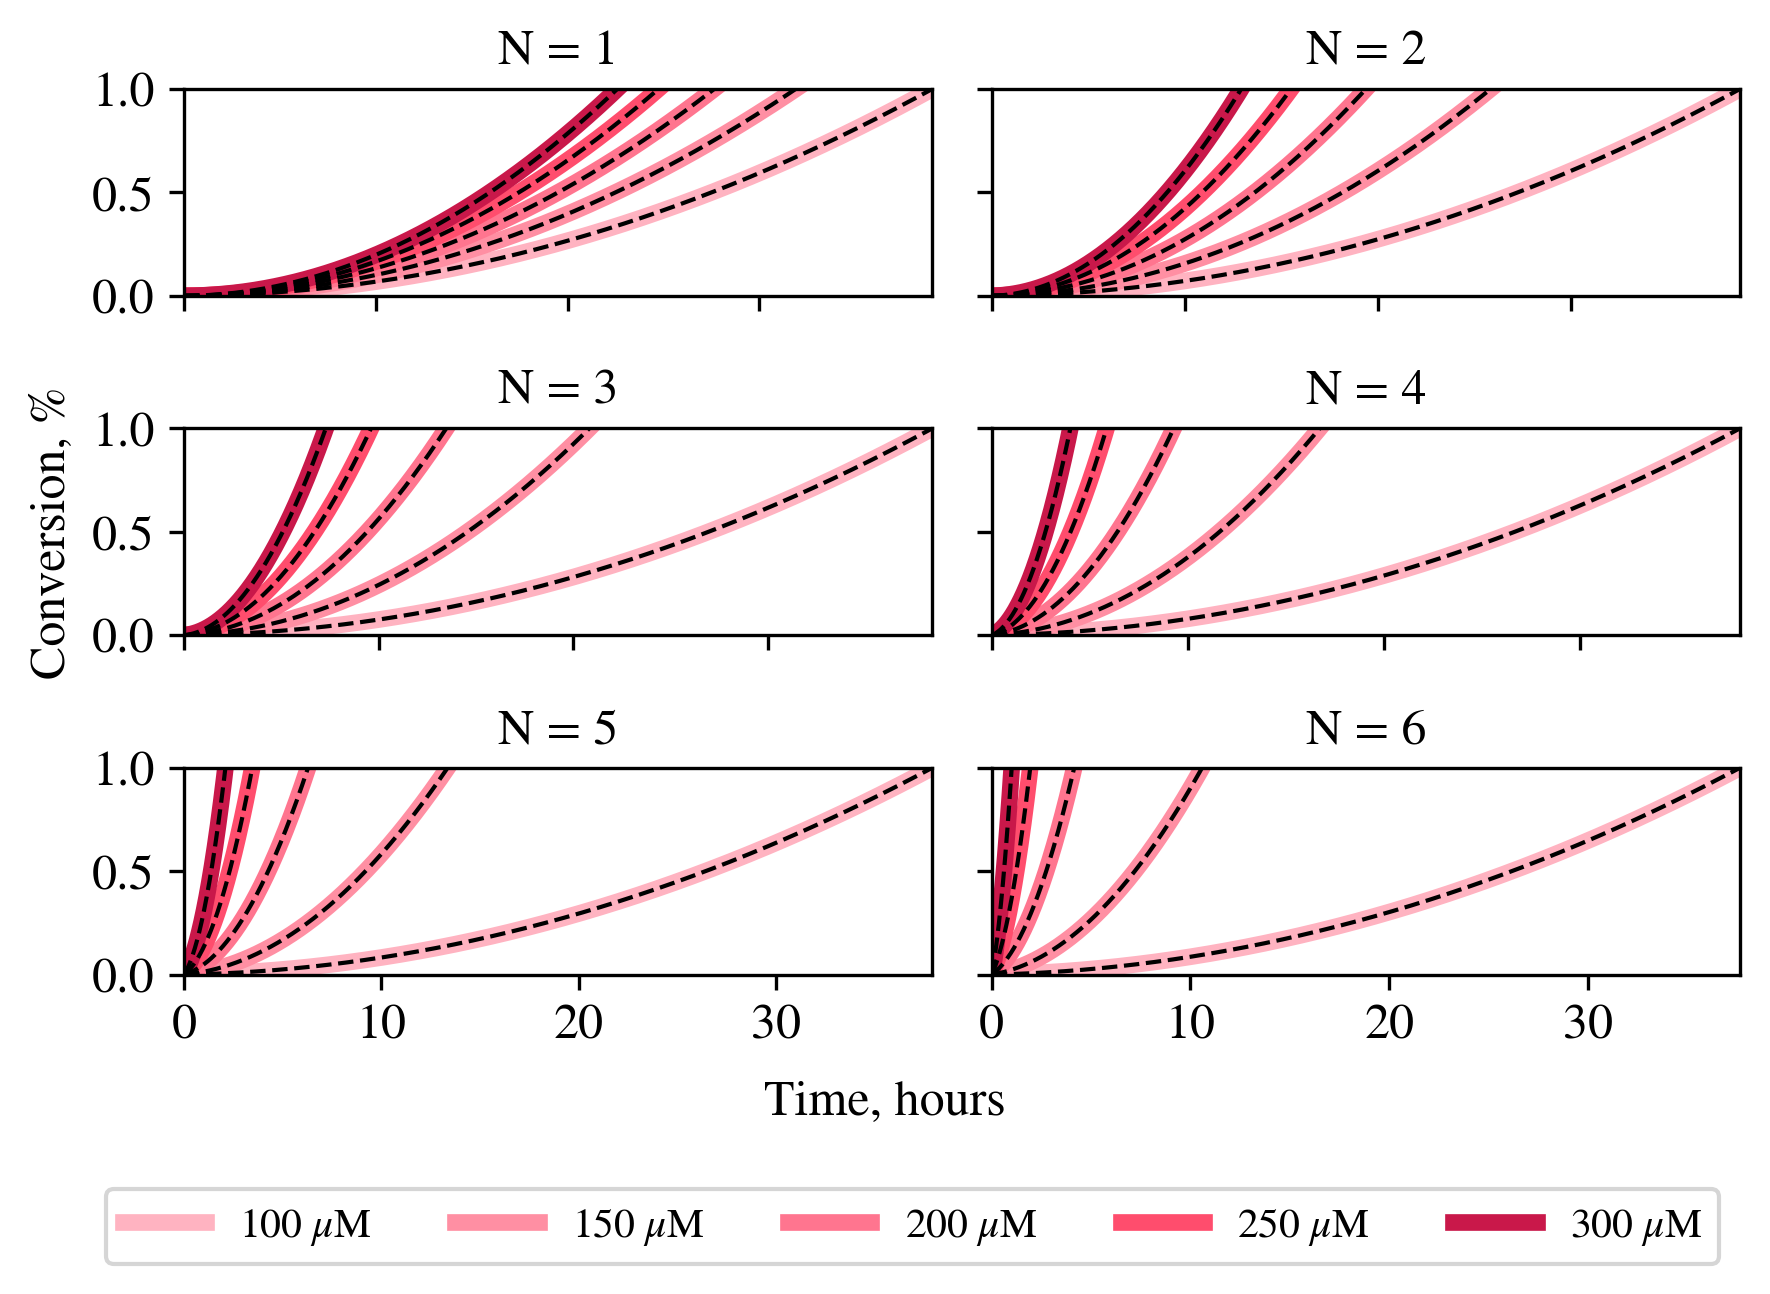

In [362]:
c = 1
K_cap = 1
k_grow = 10**1
k_frag = 0
k_eros = 0
k_surf = 0
elong_N_th_dict = dict()
calculate_series("th_kin_elong", "th_slope_elong", elong_N_th_dict, "elon")

# Elongation regime with capping


R^2 1.0
concentrations [9.999999999999999e-05, 0.00015, 0.00019999999999999998, 0.00025, 0.0003]
lag times [140428.80000000002, 126979.2, 118224.0, 111844.8, 106891.2]
R^2 precise 1.0
N 1
slope -0.25
N_th 1.25
lag times precise (h) [39.008 35.272 32.84  31.068 29.692]
lag time approx (h) [39.008 35.272 32.84  31.068 29.692]

R^2 1.0
concentrations [9.999999999999999e-05, 0.00015, 0.00019999999999999998, 0.00025, 0.0003]
lag times [139449.6, 102729.6, 82699.2, 69883.2, 60897.6]
R^2 precise 1.0
N 2
slope -0.75
N_th 1.75
lag times precise (h) [38.736 28.536 22.972 19.412 16.916]
lag time approx (h) [38.736 28.536 22.972 19.412 16.916]

R^2 1.0
concentrations [9.999999999999999e-05, 0.00015, 0.00019999999999999998, 0.00025, 0.0003]
lag times [138456.0, 82785.6, 57384.0, 43142.4, 34142.4]
R^2 precise 1.0
N 3
slope -1.27
N_th 2.55
lag times precise (h) [38.46  22.996 15.94  11.984  9.484]
lag time approx (h) [38.46  22.996 15.94  11.984  9.484]

R^2 1.0
concentrations [9.999999999999999e-05

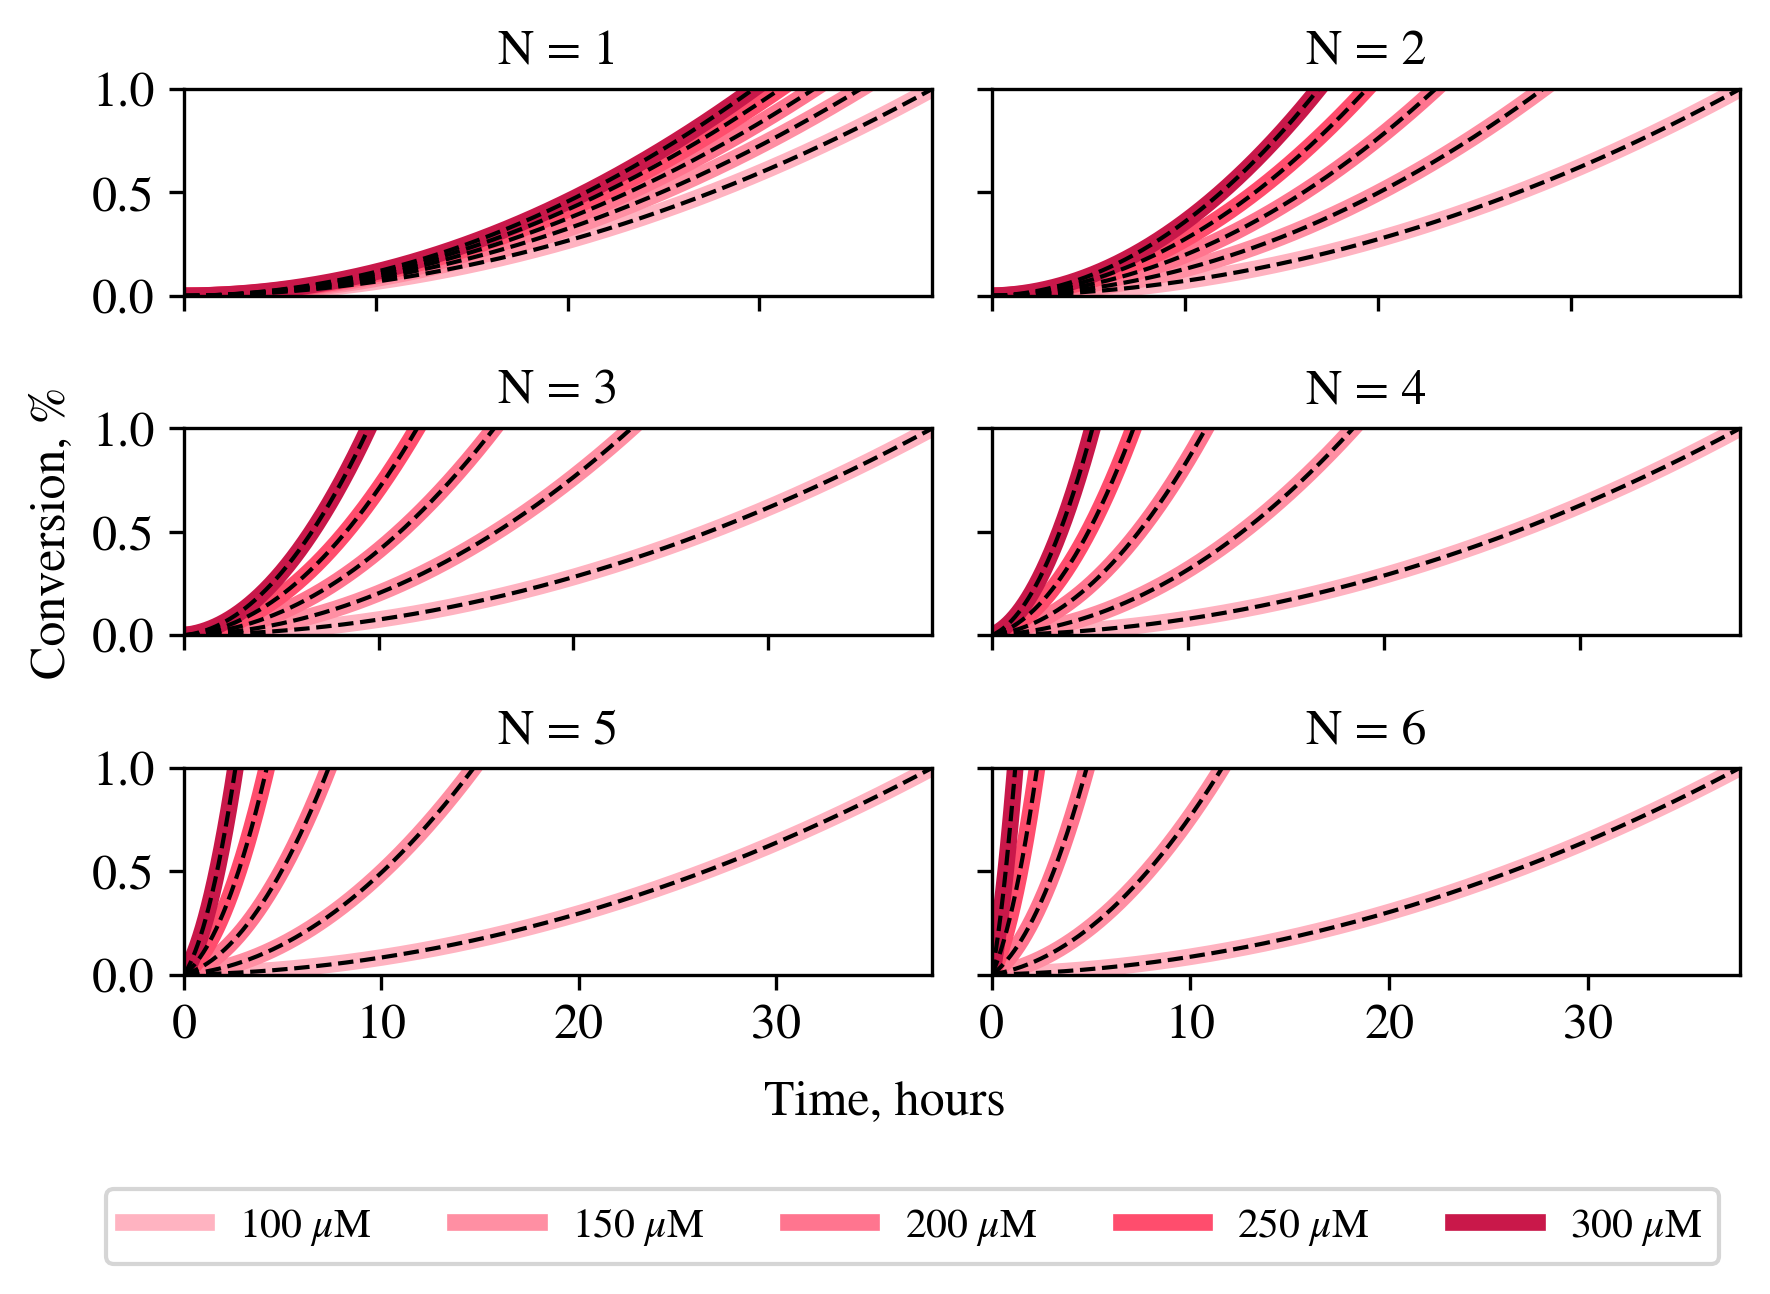

In [363]:
c = 2
K_cap = 10**4
k_grow = 10**1
k_frag = 0
k_eros = 0
k_surf = 0
elong_cap_N_th_dict = dict()
calculate_series("th_kin_elong_cap", "th_slope_elong_cap", elong_cap_N_th_dict, "capp")

# Surface nucleation regime


R^2 1.0
concentrations [9.999999999999999e-05, 0.00015, 0.00019999999999999998, 0.00025, 0.0003]
lag times [130190.40000000001, 99273.6, 79891.2, 66470.40000000001, 56620.8]
R^2 precise 1.0
N 1
slope -0.76
N_th 1.76
lag times precise (h) [36.164 27.576 22.192 18.464 15.728]
lag time approx (h) [39.004 31.888 27.636 24.732 22.584]

R^2 1.0
concentrations [9.999999999999999e-05, 0.00015, 0.00019999999999999998, 0.00025, 0.0003]
lag times [129211.2, 83505.6, 60912.0, 47520.0, 38692.8]
R^2 precise 1.0
N 2
slope -1.1
N_th 2.19
lag times precise (h) [35.892 23.196 16.92  13.2   10.748]
lag time approx (h) [38.728 25.816 19.36  15.488 12.904]

R^2 1.0
concentrations [9.999999999999999e-05, 0.00015, 0.00019999999999999998, 0.00025, 0.0003]
lag times [128232.0, 69393.6, 44841.6, 31953.600000000002, 24206.4]
R^2 precise 1.0
N 3
slope -1.52
N_th 3.03
lag times precise (h) [35.62  19.276 12.456  8.876  6.724]
lag time approx (h) [38.448 20.828 13.472  9.604  7.284]

R^2 1.0
concentrations [9.9999

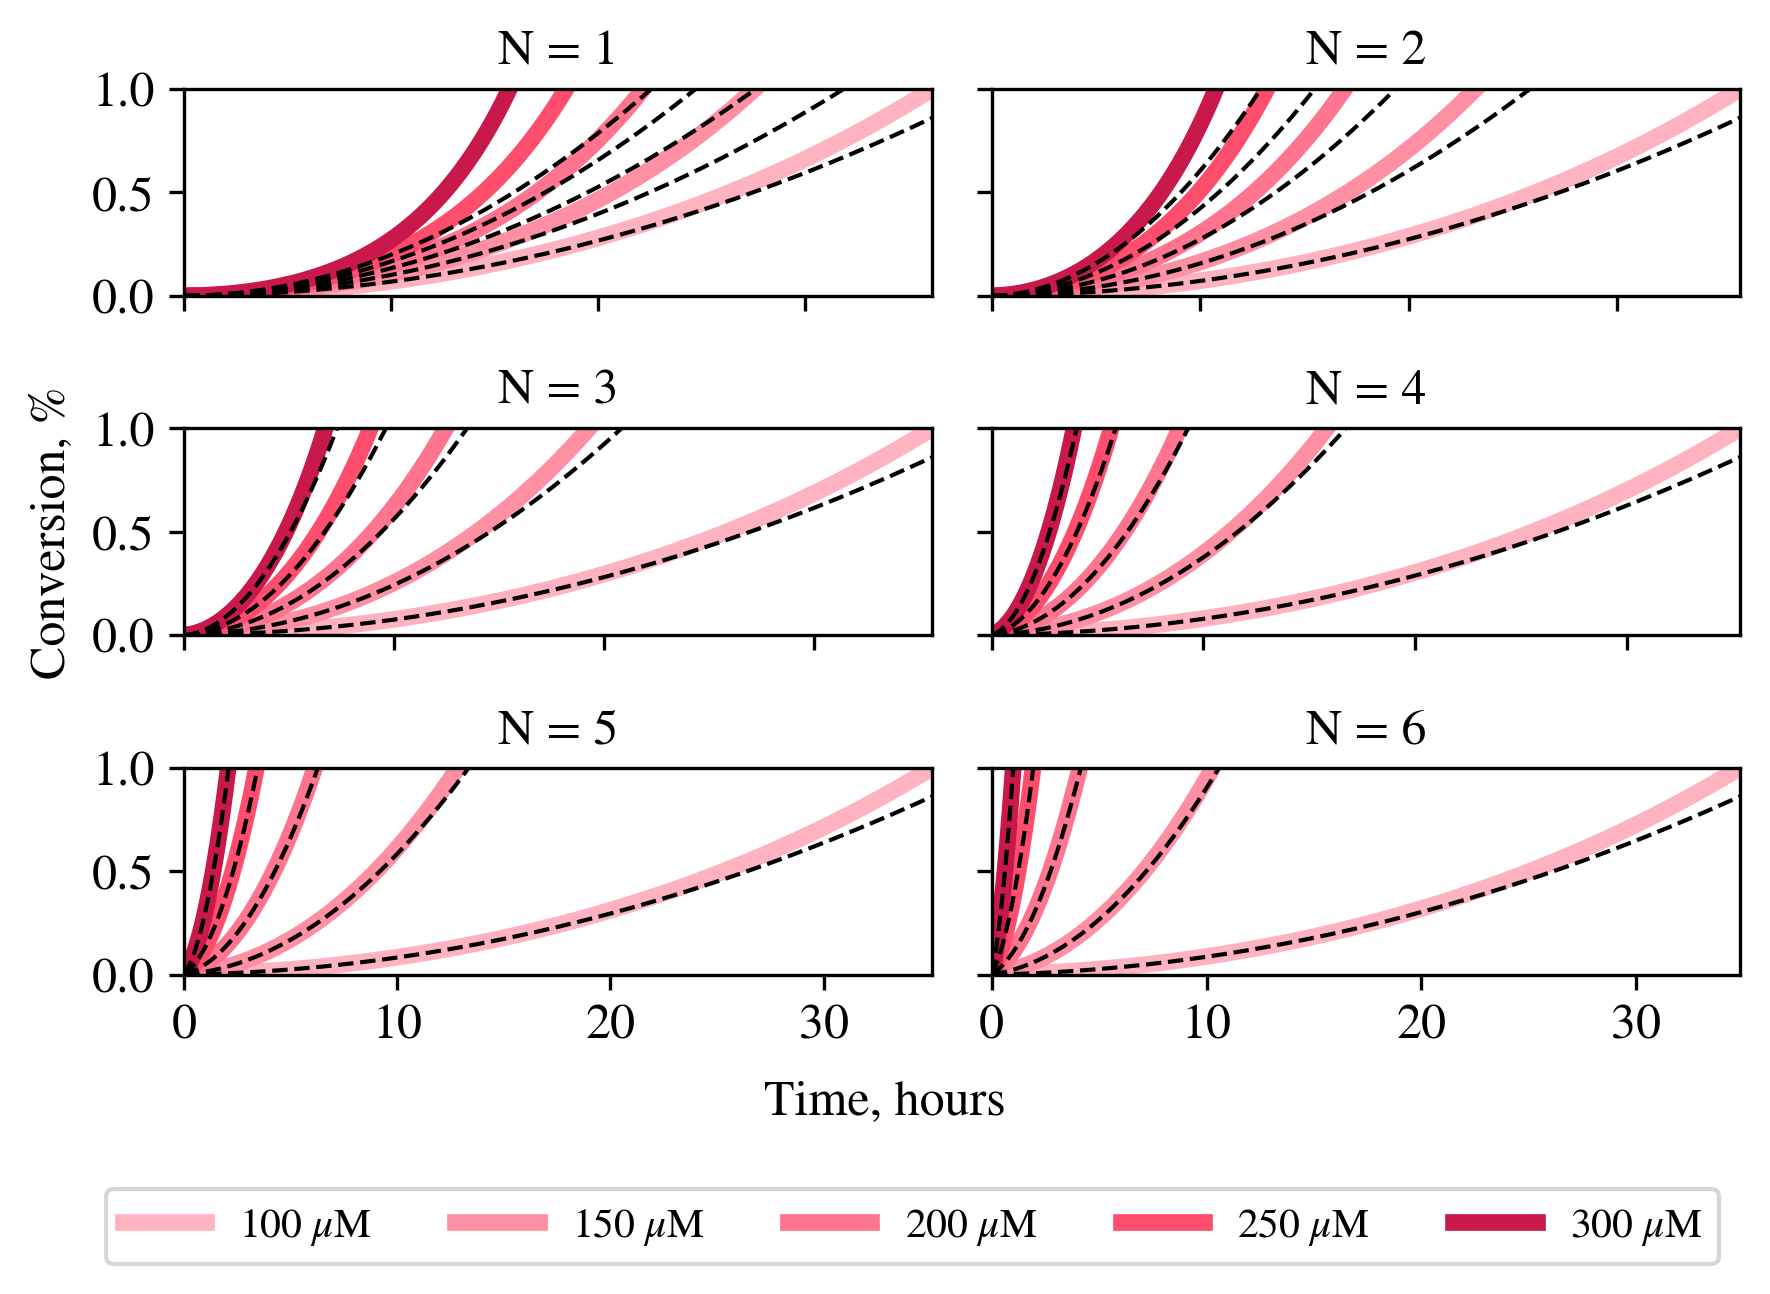

In [364]:
c = 1
K_cap = 1
k_grow = 10**1
k_frag = 0
k_eros = 0
k_surf = 10**(-2)
surf_N_th_dict = dict()
calculate_series("th_kin_surf", "th_slope_surf", surf_N_th_dict, "surf")

# Fragmentation regime


R^2 1.0
concentrations [9.999999999999999e-05, 0.00015, 0.00019999999999999998, 0.00025, 0.0003]
lag times [23184.0, 19036.8, 16560.0, 14846.4, 13579.2]
R^2 precise 1.0
N 1
slope -0.49
N_th 1.49
lag times precise (h) [6.44  5.288 4.6   4.124 3.772]
lag time approx (h) [6.68  5.452 4.724 4.224 3.856]

R^2 1.0
concentrations [9.999999999999999e-05, 0.00015, 0.00019999999999999998, 0.00025, 0.0003]
lag times [22492.8, 17510.4, 14630.4, 12715.2, 11318.4]
R^2 precise 1.0
N 2
slope -0.62
N_th 1.62
lag times precise (h) [6.248 4.864 4.064 3.532 3.144]
lag time approx (h) [6.68  5.164 4.292 3.716 3.3  ]

R^2 1.0
concentrations [9.999999999999999e-05, 0.00015, 0.00019999999999999998, 0.00025, 0.0003]
lag times [21931.2, 16070.4, 12758.4, 10612.800000000001, 9086.4]
R^2 precise 1.0
N 3
slope -0.8
N_th 1.8
lag times precise (h) [6.092 4.464 3.544 2.948 2.524]
lag time approx (h) [6.68  4.872 3.864 3.208 2.744]

R^2 1.0
concentrations [9.999999999999999e-05, 0.00015, 0.00019999999999999998, 0.000

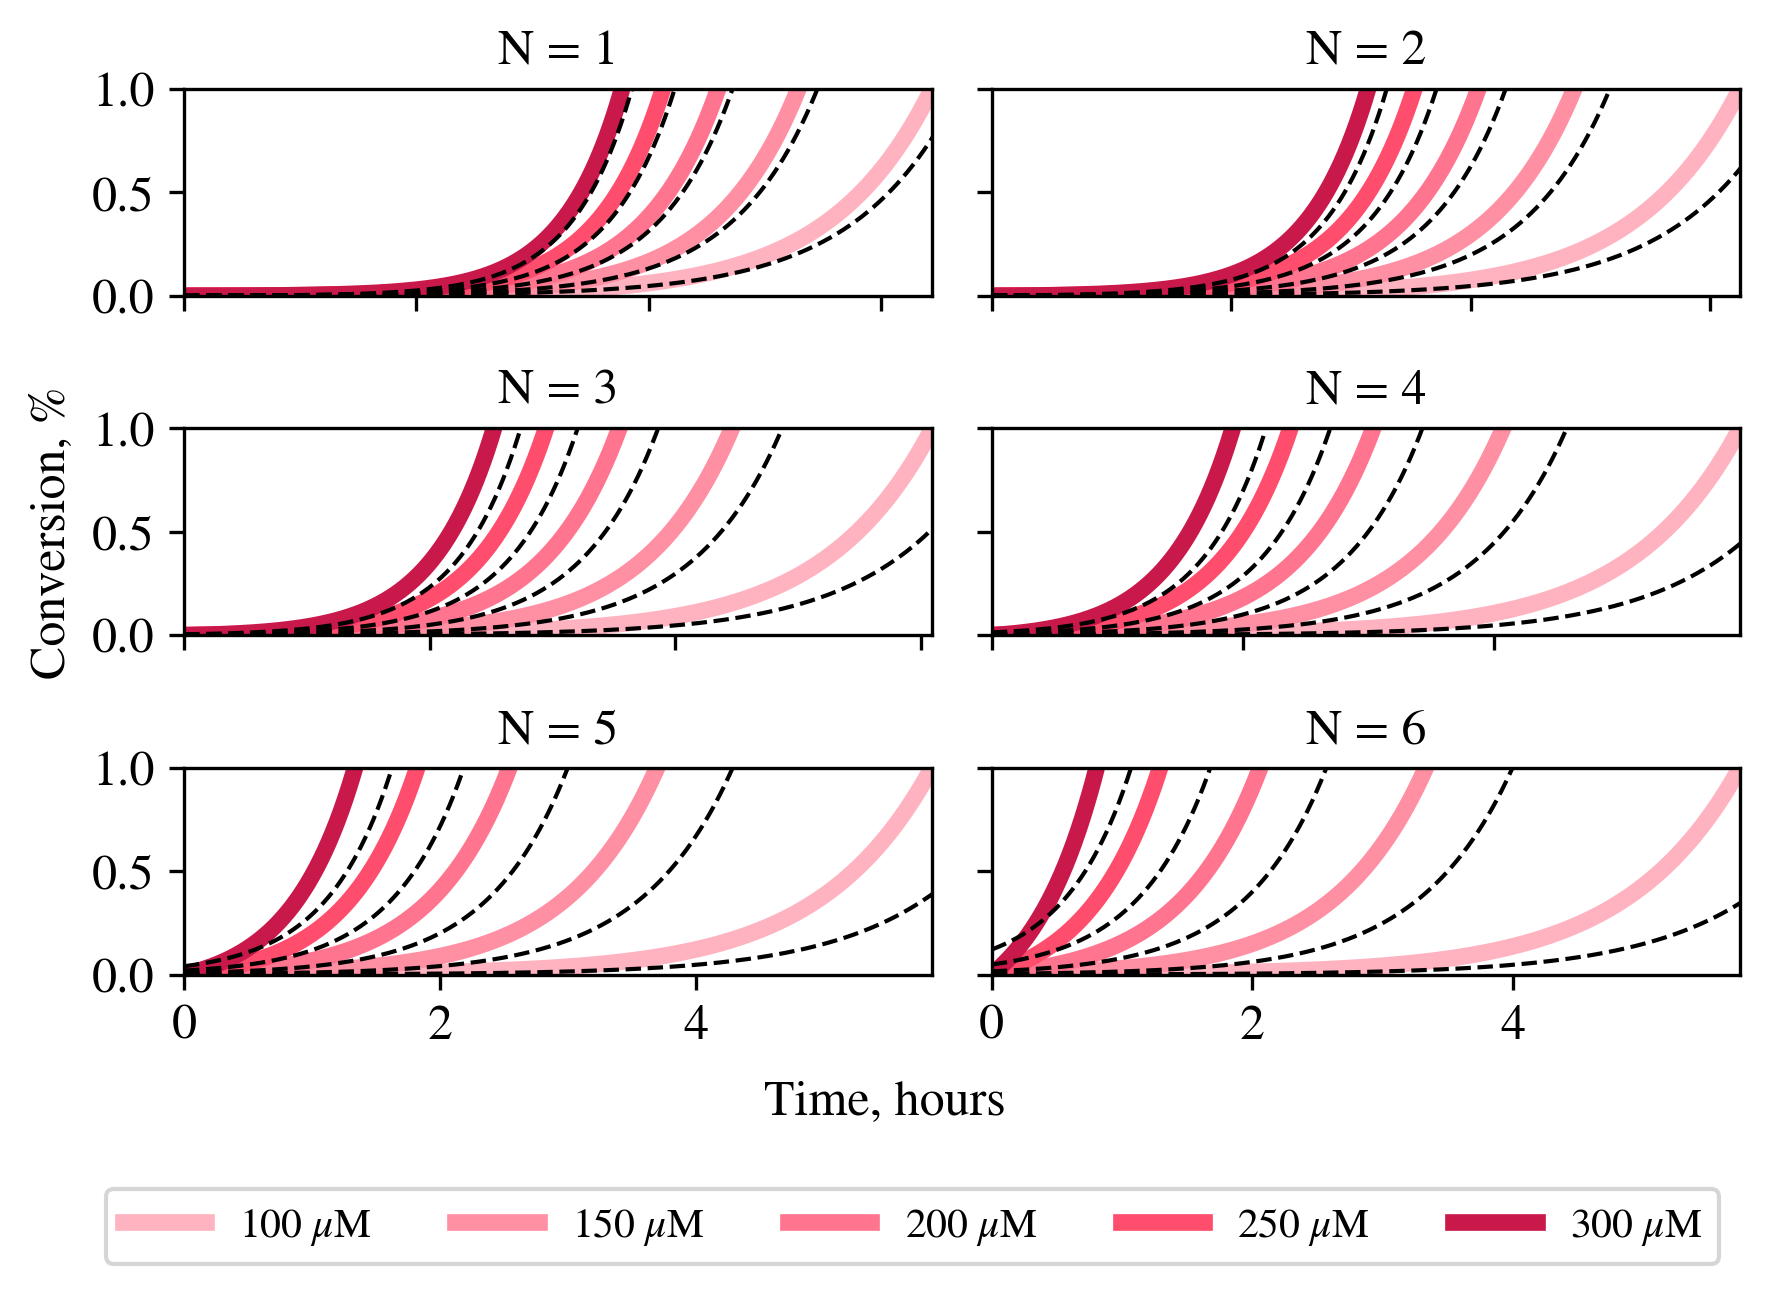

In [365]:
c = 1
K_cap = 1
k_grow = 10**1
k_frag = 10**(-4)
k_eros = 0
k_surf = 0
frag_N_th_dict = dict()
calculate_series("th_kin_frag", "th_slope_frag", frag_N_th_dict, "frag")

# Erosion regime


R^2 1.0
concentrations [9.999999999999999e-05, 0.00015, 0.00019999999999999998, 0.00025, 0.0003]
lag times [9216.0, 8812.800000000001, 8524.800000000001, 8308.800000000001, 8121.6]
R^2 precise 1.0
N 1
slope -0.11
N_th 1.11
lag times precise (h) [2.56  2.448 2.368 2.308 2.256]
lag time approx (h) [2.56  2.448 2.368 2.304 2.256]

R^2 1.0
concentrations [9.999999999999999e-05, 0.00015, 0.00019999999999999998, 0.00025, 0.0003]
lag times [9216.0, 8409.6, 7833.6, 7387.2, 7027.2]
R^2 precise 1.0
N 2
slope -0.25
N_th 1.25
lag times precise (h) [2.56  2.336 2.176 2.052 1.952]
lag time approx (h) [2.56  2.336 2.176 2.052 1.952]

R^2 1.0
concentrations [9.999999999999999e-05, 0.00015, 0.00019999999999999998, 0.00025, 0.0003]
lag times [9216.0, 7992.0, 7142.400000000001, 6465.6, 5918.400000000001]
R^2 precise 1.0
N 3
slope -0.4
N_th 1.4
lag times precise (h) [2.56  2.22  1.984 1.796 1.644]
lag time approx (h) [2.56  2.224 1.984 1.796 1.644]

R^2 1.0
concentrations [9.999999999999999e-05, 0.00015,

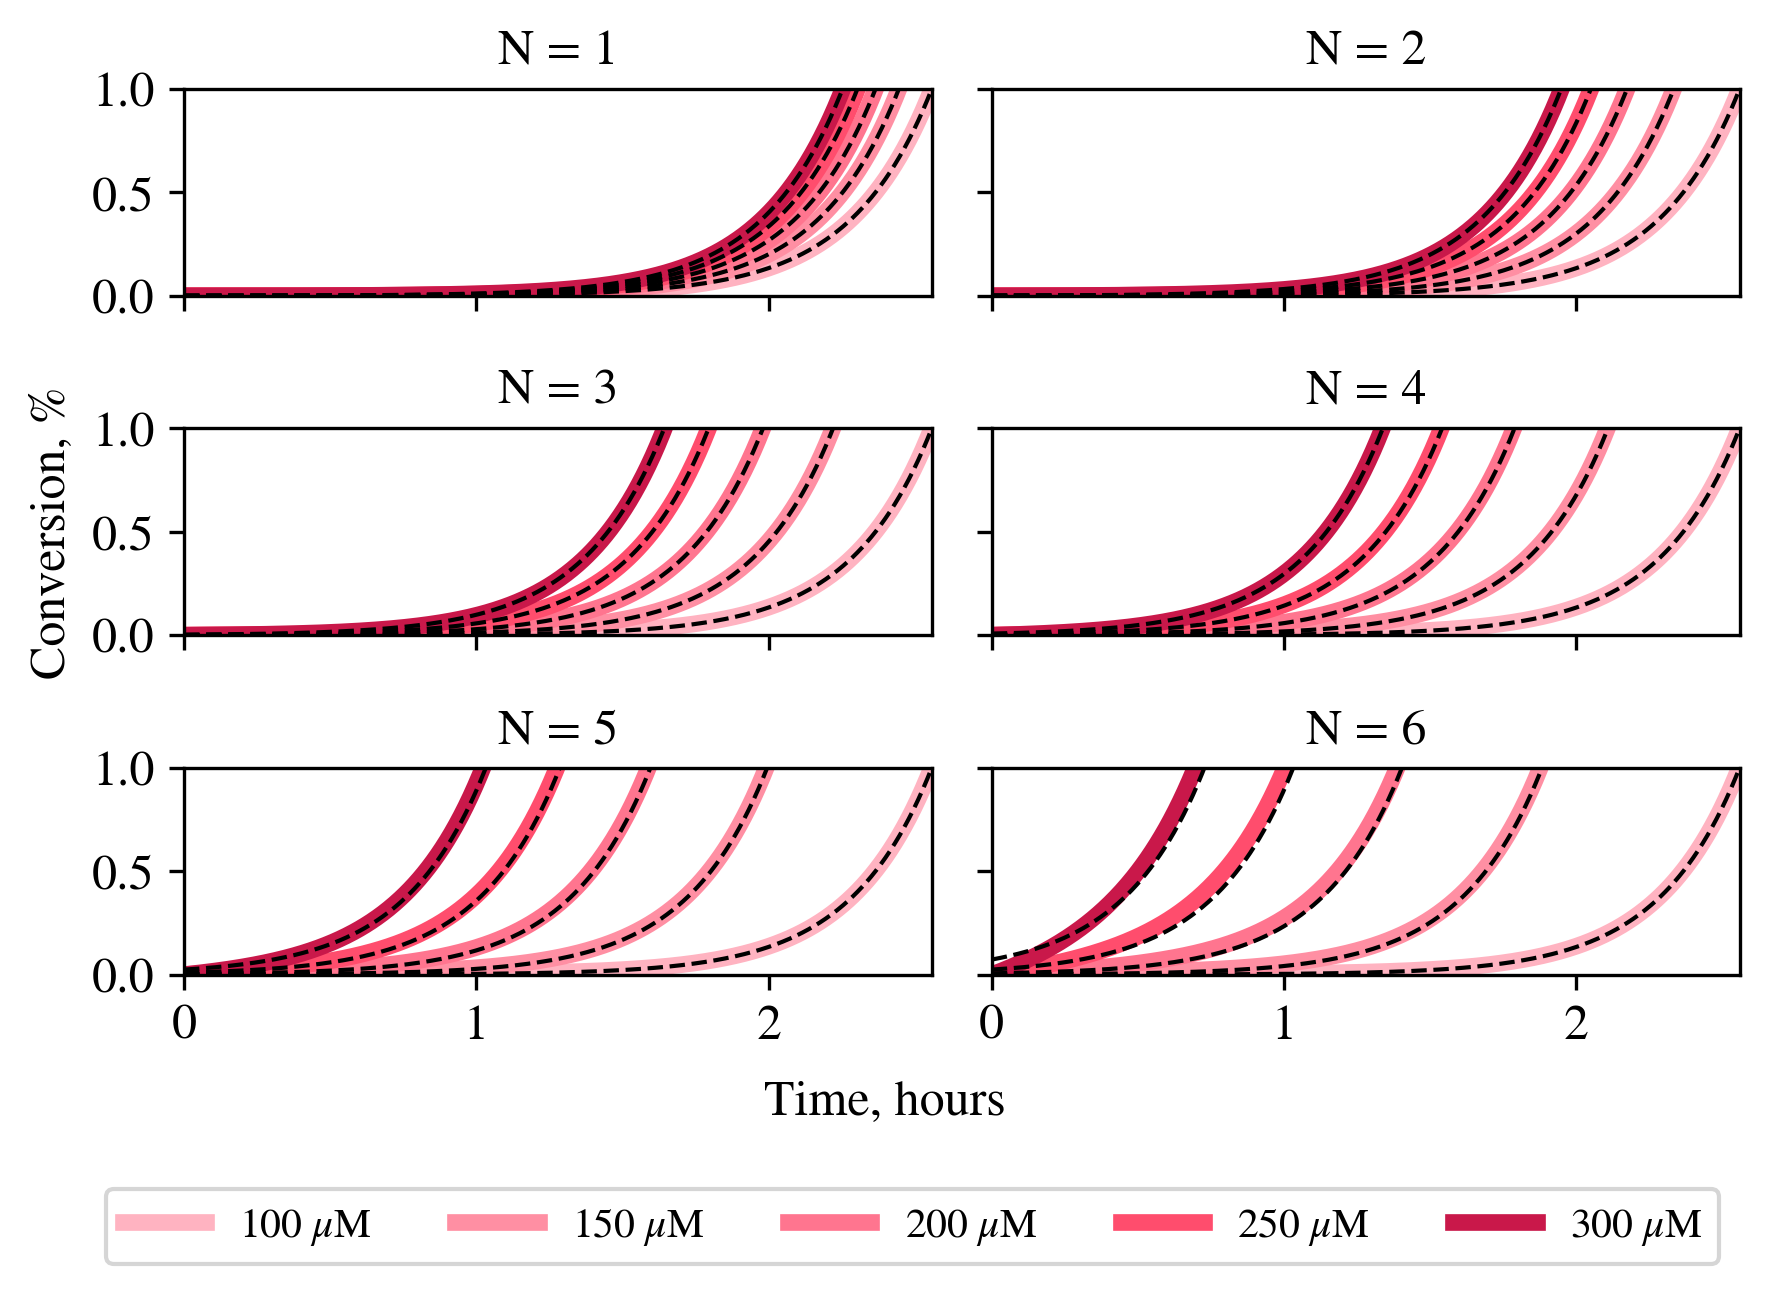

In [366]:
c = 1
K_cap = 1
k_grow = 10**1
k_frag = 0
k_eros = 10**(-3)
k_surf = 0
eros_N_th_dict = dict()
calculate_series("th_kin_eros", "th_slope_eros", eros_N_th_dict, "eros")

# Plot nuclei sizes versus calculated by slope

###
1 -> 1.5
2 -> 2.0
3 -> 3.03
4 -> 4.1
5 -> 5.26
6 -> 6.58
###
1 -> 1.25
2 -> 1.75
3 -> 2.55
4 -> 3.65
5 -> 4.86
6 -> 6.27
###
1 -> 1.49
2 -> 1.62
3 -> 1.8
4 -> 2.06
5 -> 2.66
6 -> 3.52


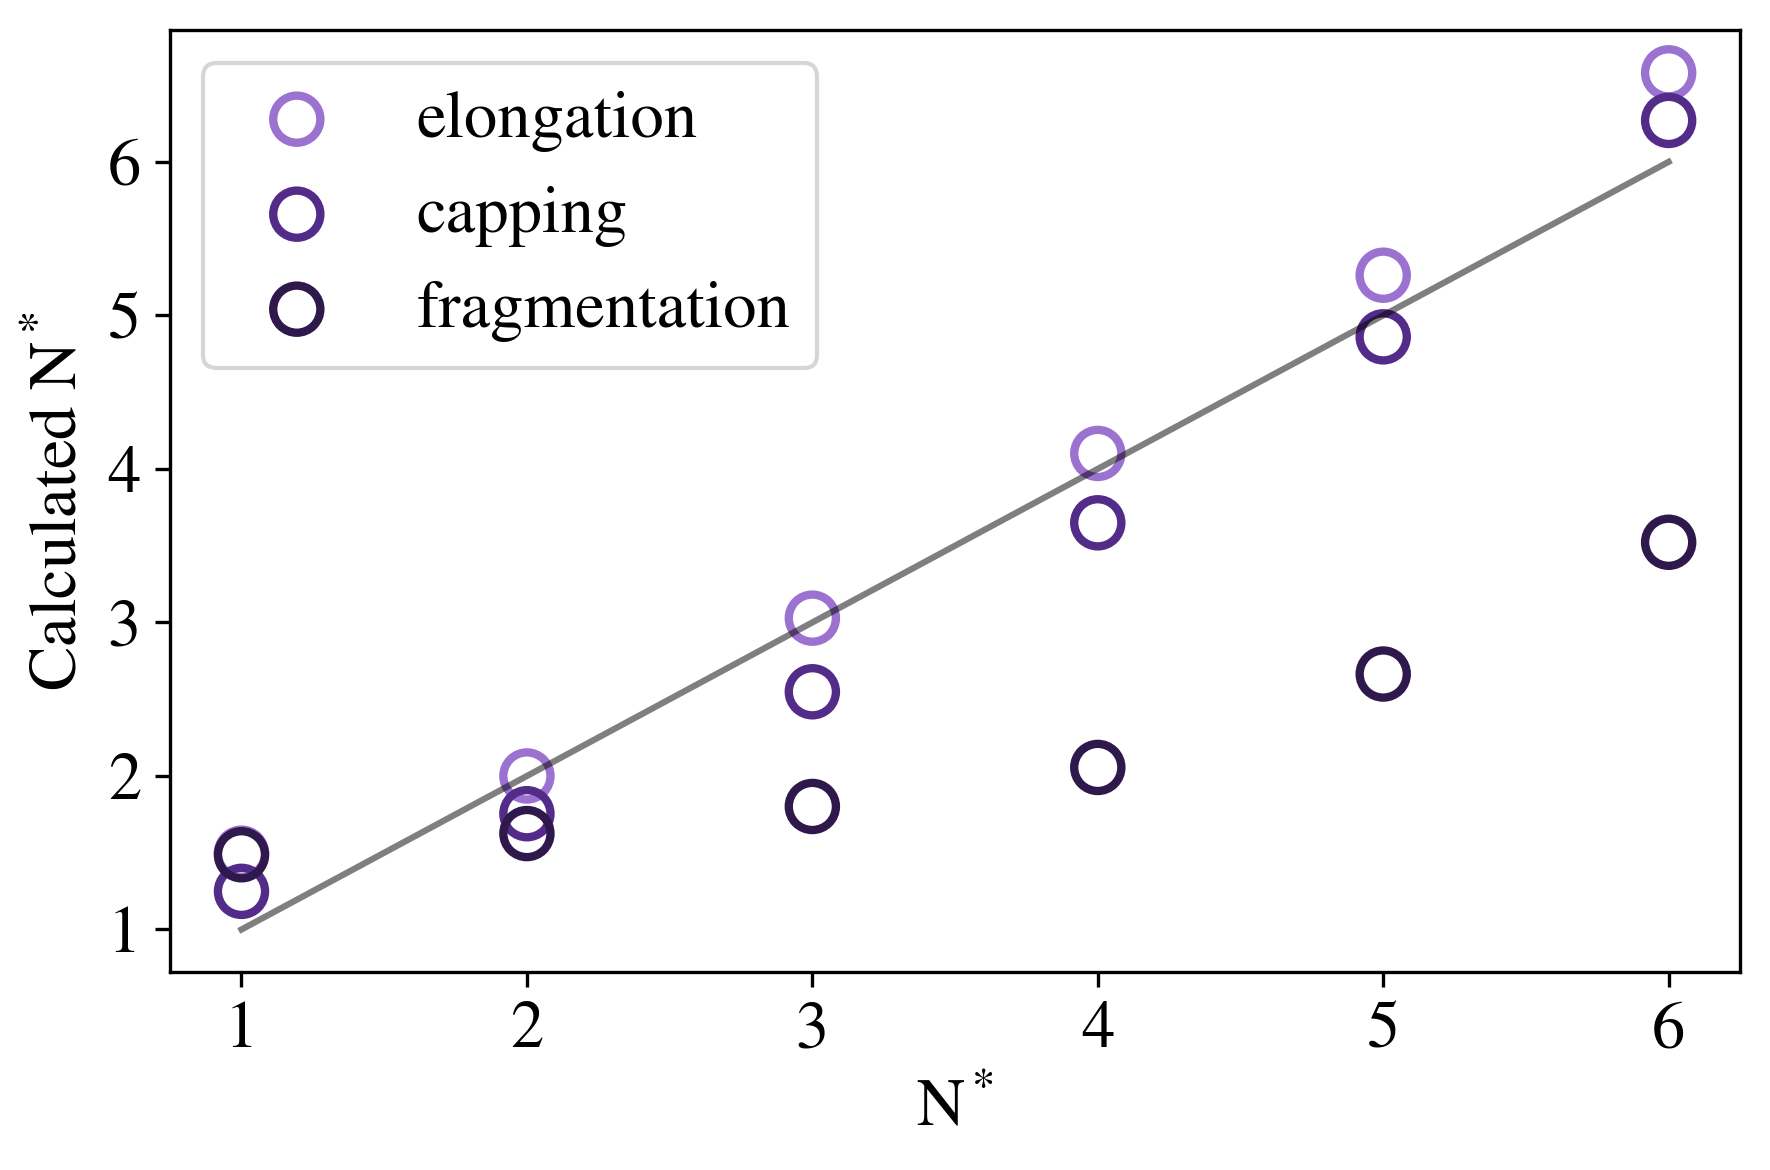

In [367]:
for N_dict in [(elong_N_th_dict, "#9b72cf", "elongation"),
               (elong_cap_N_th_dict, "#532b88", "capping"),
               (frag_N_th_dict, "#2f184b", "fragmentation")]:
    N_list, N_calc_list = [], []

    print("###")

    for N in set(N_dict[0].keys()):
        N_list.append(N)
        N_calc_list.append(N_dict[0][N])
        print(N, "->", round(N_dict[0][N], 2))

    plot.scatter(N_list, N_calc_list, label=N_dict[2],
                 color="none", edgecolor=N_dict[1], linewidth=2, s=128)

plot.plot(N_list, N_list, color="black", alpha=0.5)
plot.locator_params(axis="x", nbins=6)
plot.locator_params(axis="y", nbins=12)
plot.xticks(fontsize=16)
plot.yticks(fontsize=16)
plot.xlabel(r"N$^*$", fontsize=16)
plot.ylabel(r"Calculated N$^*$", fontsize=16)
plot.legend(fontsize=16)
plot.tight_layout()
plot.savefig("fig/th_N.png")
plot.show()

# Coordinates for fragmentation regimes

-25.417131688786284
-25.55223567065599
-24.931371375846325
-23.64411701071563
-21.71637132048457


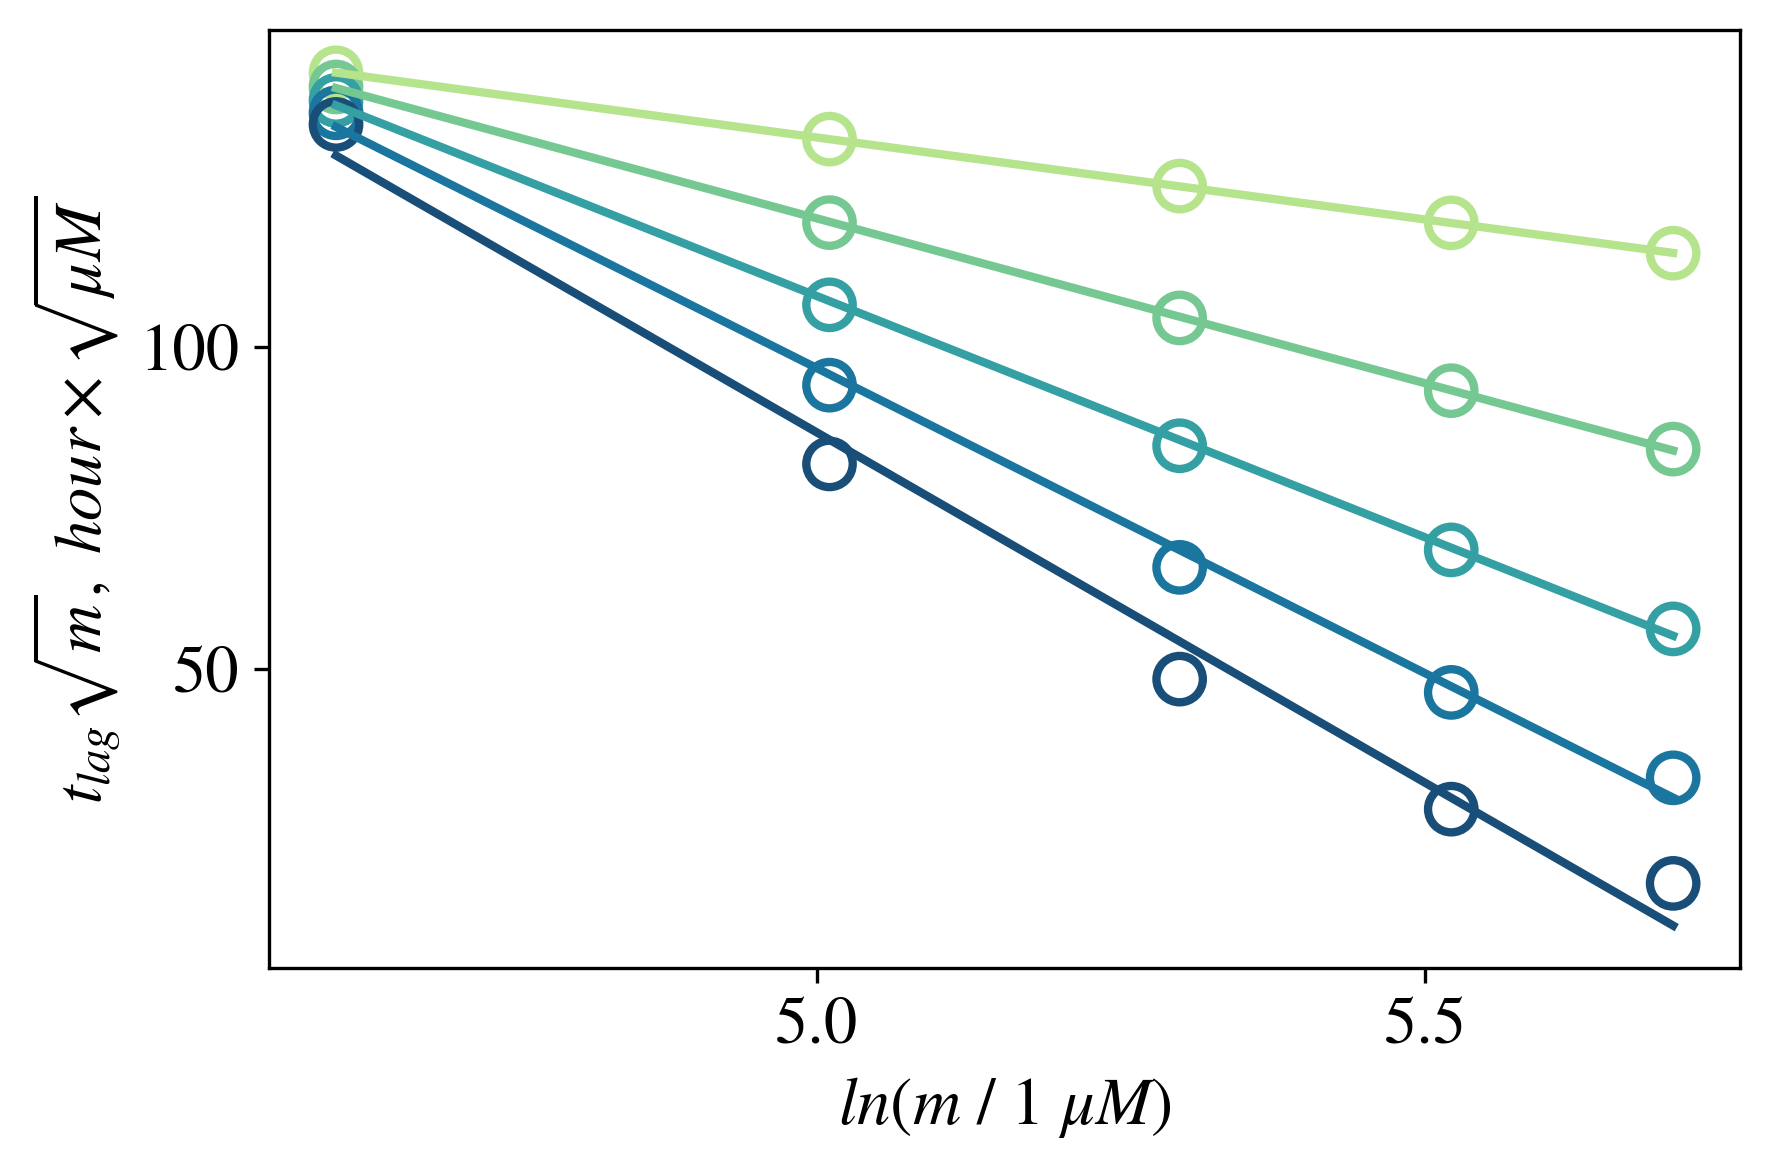

In [368]:
def get_frag_slope(m_iterable, t_lag_iterable, N) -> float:
    m_scaled_list, t_lag_scaled_list = [], []

    for i in range(len(m_iterable)):
        m, t_lag = m_iterable[i] * 10**6, t_lag_iterable[i] / 60 / 60
        m_scaled_list.append(ln(m))
        t_lag_scaled_list.append(t_lag * m**(1/2))

    m_scaled_arr = np.array(m_scaled_list, dtype=float)
    t_lag_scaled_arr = np.array(t_lag_scaled_list, dtype=float)

    plot.scatter(m_scaled_list, t_lag_scaled_list, color="none", edgecolor=N_color_list[N-1], s=124, linewidth=2)

    regr = stats.linregress(m_scaled_list, t_lag_scaled_list)

    plot.plot(m_scaled_list, np.array(m_scaled_list, dtype=float) * regr.slope + regr.intercept,
              color=N_color_list[N-1], linewidth=2)

    return regr.slope


#print(1 / (k_grow * k_frag_rand)**(1/2))
print(get_frag_slope([9.999999999999999e-05, 0.00015, 0.00019999999999999998, 0.00025, 0.0003],
                     [51264.0, 38836.8, 31780.8, 27129.600000000002, 23788.8], 2))
print(get_frag_slope([9.999999999999999e-05, 0.00015, 0.00019999999999999998, 0.00025, 0.0003],
                     [50472.0, 35035.200000000004, 26582.4, 21211.2, 17481.600000000002], 3) / 2)
print(get_frag_slope([9.999999999999999e-05, 0.00015, 0.00019999999999999998, 0.00025, 0.0003],
                     [49723.200000000004, 31291.2, 21542.4, 15595.2, 11692.800000000001], 4) / 3)
print(get_frag_slope([9.999999999999999e-05, 0.00015, 0.00019999999999999998, 0.00025, 0.0003],
                     [49032.0, 27633.600000000002, 16747.2, 10569.6, 6897.6], 5) / 4)
print(get_frag_slope([9.999999999999999e-05, 0.00015, 0.00019999999999999998, 0.00025, 0.0003],
                     [48384.0, 24048.0, 12340.800000000001, 6451.2, 3499.2000000000003], 6) / 5)

plot.xlabel(r"$ln(m\ /\ 1\ \mu M)$", fontsize=16)
plot.ylabel(r"$t_{lag} \sqrt{m},\ hour \times \sqrt{\mu M}$", fontsize=16)
plot.xticks(fontsize=16)
plot.yticks(fontsize=16)
plot.locator_params(axis="x", nbins=1)
plot.locator_params(axis="y", nbins=5)
plot.tight_layout()
plot.savefig("fig/rand frag line.png")
plot.show()

# Coordinates for erosion regime

-0.5539279600932997
-0.8330469582685903
-1.1111655425442204
-1.3988385884263543
-1.6991241153056693


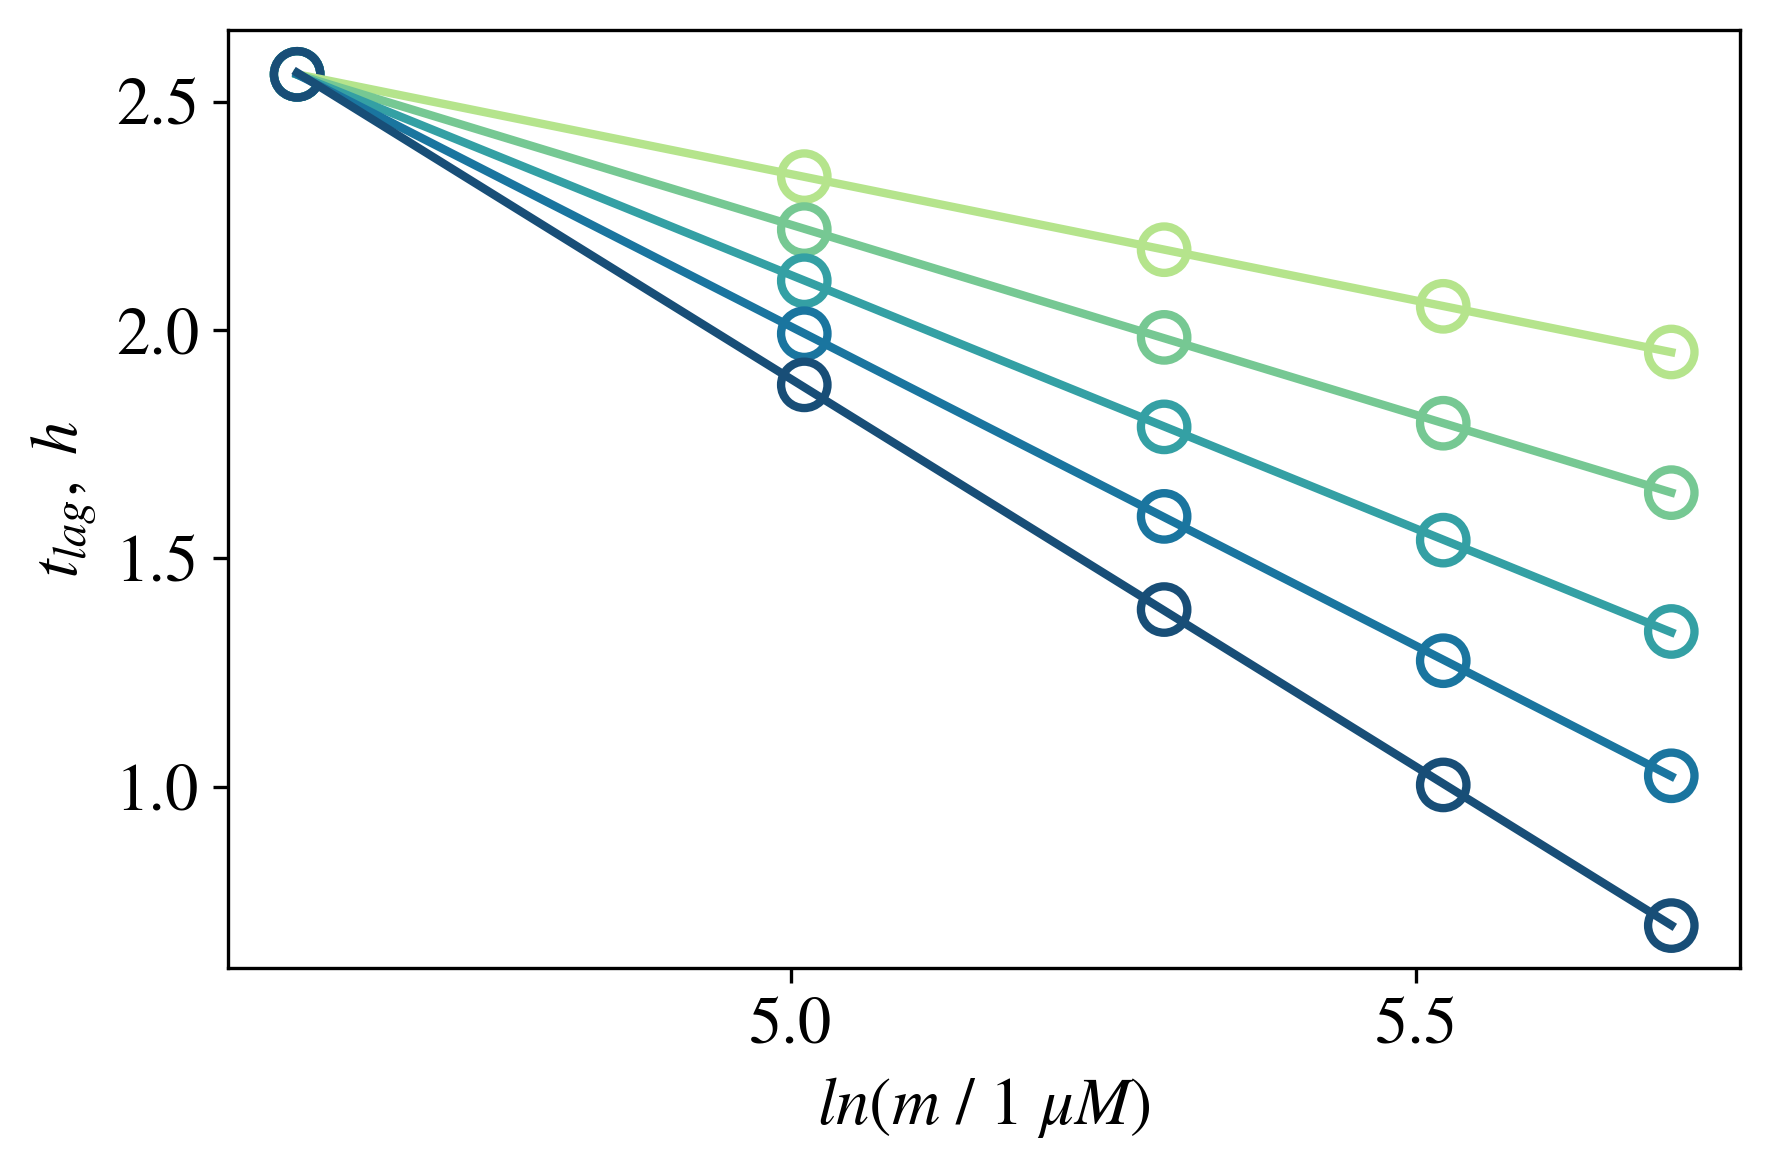

In [369]:
def get_eros_slope(m_iterable, t_lag_iterable, N) -> float:
    m_scaled_list, t_lag_scaled_list = [], []

    for i in range(len(m_iterable)):
        m, t_lag = m_iterable[i], t_lag_iterable[i]
        m_scaled_list.append(ln(m * 10**6))
        t_lag_scaled_list.append(t_lag)

    m_scaled_arr = np.array(m_scaled_list, dtype=float)
    t_lag_scaled_arr = np.array(t_lag_scaled_list, dtype=float) / 60 / 60

    plot.scatter(m_scaled_arr, t_lag_scaled_arr, color="none", edgecolor=N_color_list[N-1], s=124, linewidth=2)
    
    regr = stats.linregress(m_scaled_arr, t_lag_scaled_arr)
    
    plot.plot(m_scaled_arr, m_scaled_arr * regr.slope + regr.intercept,
              color=N_color_list[N-1], linewidth=2)

    return regr.slope


#print(1 / (k_grow * k_frag_rand)**(1/2))
print(get_eros_slope([9.999999999999999e-05, 0.00015, 0.00019999999999999998, 0.00025, 0.0003],
                     [9216.0, 8409.6, 7833.6, 7387.2, 7027.2], 2))
print(get_eros_slope([9.999999999999999e-05, 0.00015, 0.00019999999999999998, 0.00025, 0.0003],
                     [9216.0, 7992.0, 7142.400000000001, 6465.6, 5918.400000000001], 3))
print(get_eros_slope([9.999999999999999e-05, 0.00015, 0.00019999999999999998, 0.00025, 0.0003],
                     [9216.0, 7588.8, 6436.8, 5544.0, 4824.0], 4))
print(get_eros_slope([9.999999999999999e-05, 0.00015, 0.00019999999999999998, 0.00025, 0.0003],
                     [9216.0, 7171.2, 5731.2, 4593.6, 3686.4], 5))
print(get_eros_slope([9.999999999999999e-05, 0.00015, 0.00019999999999999998, 0.00025, 0.0003],
                     [9216.0, 6768.0, 4996.8, 3614.4, 2505.6], 6))

plot.xlabel(r"$ln(m\ /\ 1\ \mu M)$", fontsize=16)
plot.ylabel(r"$t_{lag},\ h$", fontsize=16)
plot.xticks(fontsize=16)
plot.yticks(fontsize=16)
plot.locator_params(axis="x", nbins=1)
plot.locator_params(axis="y", nbins=5)
plot.tight_layout()
plot.savefig("fig/eros line.png")
plot.show()

# Average aggregate size

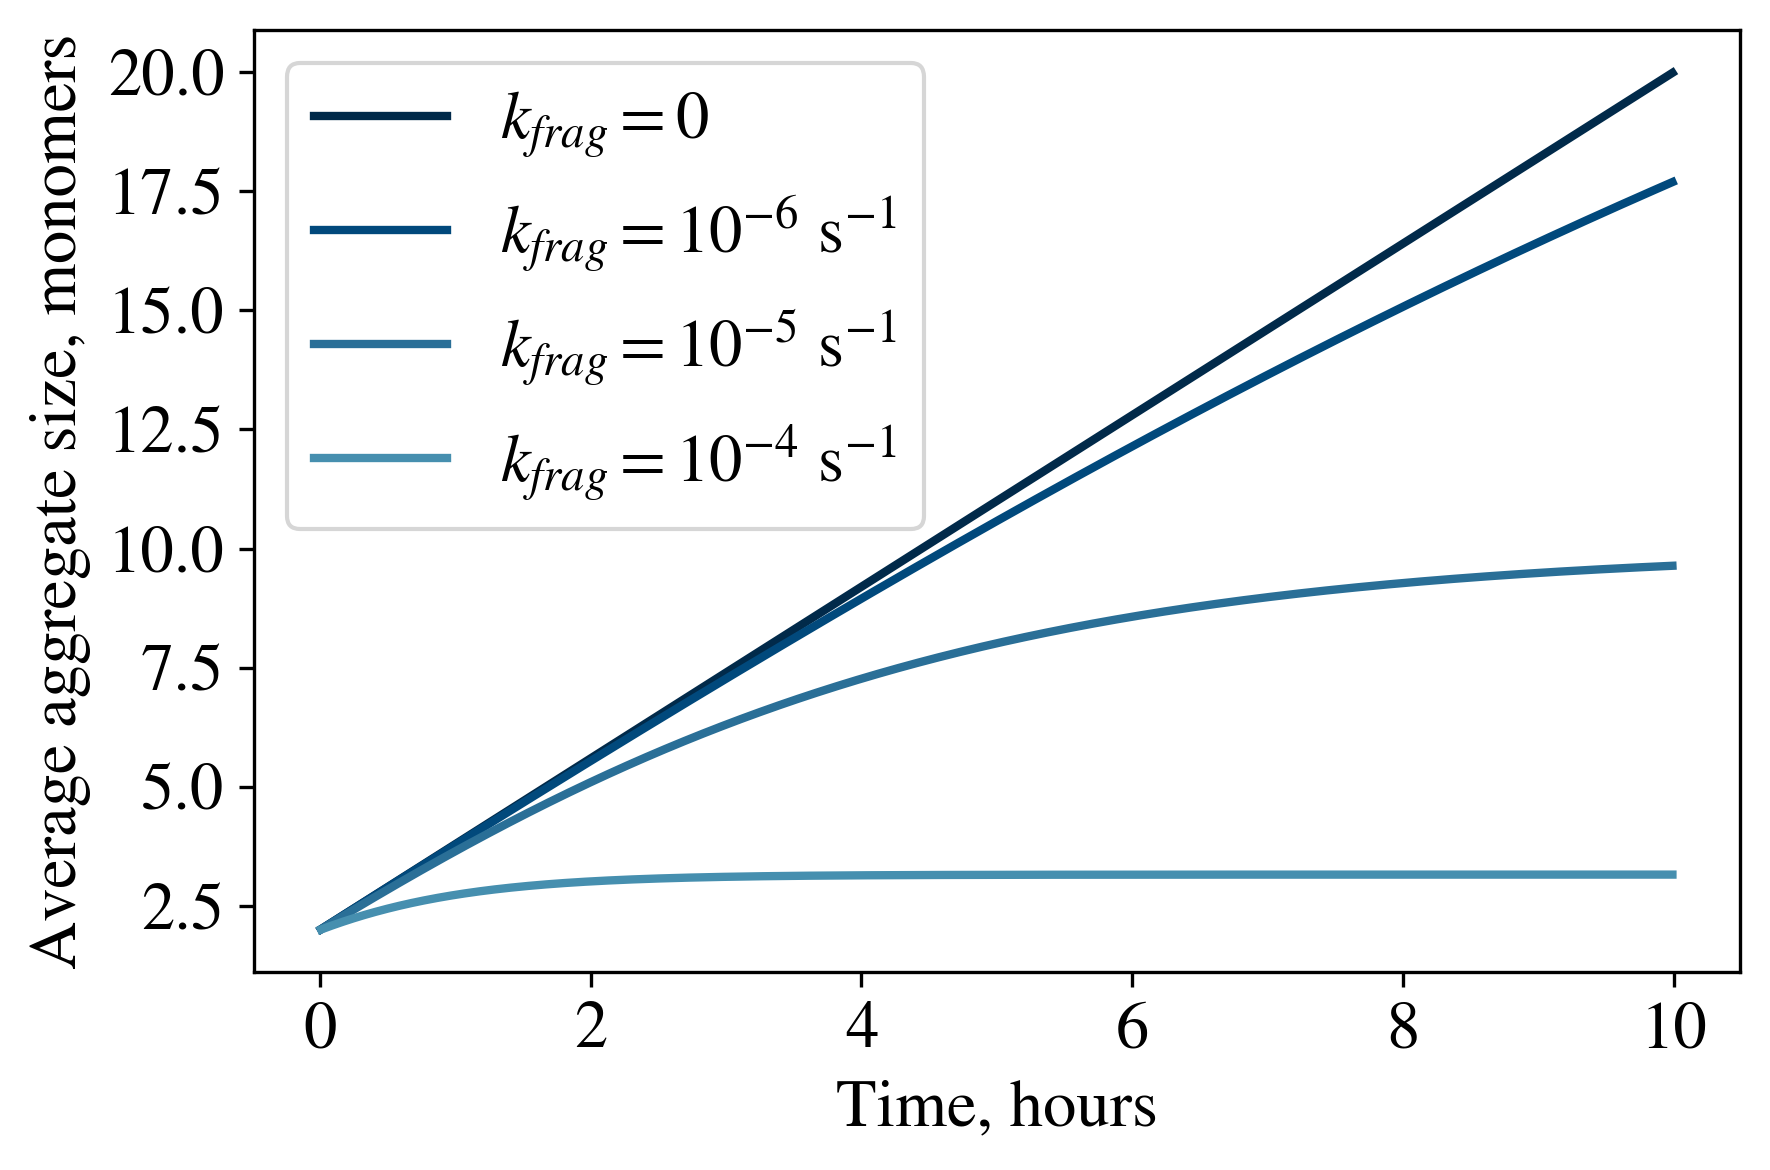

In [370]:
def get_N_aver_elon(t: float) -> float:
    if t == 0:
        return 0

    return (A * t + A * C * t**2 / (2 * N)) / (A / N * t)


def get_N_aver_frag(t: float, k_frag: float) -> float:
    E = k_frag
    assert E > 0
    
    if t == 0:
        return 0

    Delta = (B - D)**2 + 4 * C * (E + B / s)
    ev_1 = (B + D + Delta**(1/2)) / 2
    ev_2 = (B + D - Delta**(1/2)) / 2
    
    M = A * s * (C - D * N) / N / (D * B * s - B * C - C * E * s)
    m_beta = M + ((A + ev_2 * M) * exp(ev_1 * t) - \
                  (A + ev_1 * M) * exp(ev_2 * t)) / (ev_1 - ev_2)
    a_1 = (A + ev_2 * M) / (ev_1 - ev_2)
    a_2 = -(A + ev_1 * M) / (ev_1 - ev_2)
    m_aggr = (a_1 * ev_1 * exp(ev_1 * t) + a_2 * ev_2 * exp(ev_2 * t) - B * (M + a_1 * exp(ev_1 * t) + a_2 * exp(ev_2 * t)) - A) / C
    
    return m_beta / m_aggr


c = 1
K_cap = 1
k_grow = 10**1
k_frag = 10**(-4)
k_eros = 0
k_surf = 0
N = 2
K_N = 10**(4*(N-1))
m = 100*10**(-6)

A = N * k_N * K_N * m**N
B = s * k_surf * K_surf * m**s
C = k_grow * (m / K_cap)**(1/c)
D = k_eros
E = k_frag

t_arr = np.arange(0.01, 10, 0.01) * 60 * 60
N_aver_elon_list, N_aver_frag_6_list, N_aver_frag_5_list, N_aver_frag_4_list = [], [], [], []
for t in t_arr:
    N_aver_elon_list.append(get_N_aver_elon(t))
    N_aver_frag_6_list.append(get_N_aver_frag(t, 10**(-6)))
    N_aver_frag_5_list.append(get_N_aver_frag(t, 10**(-5)))
    N_aver_frag_4_list.append(get_N_aver_frag(t, 10**(-4)))

plot.plot(t_arr / 60 / 60, N_aver_elon_list, linewidth=2, color="#012a4a", label=r"$k_{frag} = 0$")
plot.plot(t_arr / 60 / 60, N_aver_frag_6_list, linewidth=2, color="#01497c", label=r"$k_{frag} = 10^{-6}$ s$^{-1}$")
plot.plot(t_arr / 60 / 60, N_aver_frag_5_list, linewidth=2, color="#2a6f97", label=r"$k_{frag} = 10^{-5}$ s$^{-1}$")
plot.plot(t_arr / 60 / 60, N_aver_frag_4_list, linewidth=2, color="#468faf", label=r"$k_{frag} = 10^{-4}$ s$^{-1}$")
plot.xlabel("Time, hours", fontsize=16)
plot.ylabel("Average aggregate size, monomers", fontsize=16)
plot.xticks(fontsize=16)
plot.yticks(fontsize=16)
plot.legend(fontsize=16)
plot.tight_layout()
plot.savefig("fig/aver.png")
plot.show()

# Building plots for experimental data

### PEPTIDE ###
A$\beta$40
###############
R^2_1 1.0
slope_1 -0.44 
    N_tan_1 1.88 
    N_elong_1 1.44 
    N_cap_1 1.44 
    N_frag_1 2.19
R^2_2 0.99
slope_2 -0.42 
    N_tan_2 1.85 
    N_elong_2 1.42 
    N_cap_2 1.42 
    N_frag_2 2.12
slope log log -0.26 
    R^2 log log 0.88 
    N_tan 1.51 
    N_elong 1.26 
    N_cap 1.26 
    N_frag 1.36 
    slope_eros 
    R^2 eros 
    slope_frag 
    R^2 frag 
   

### PEPTIDE ###
A$\beta$40
###############
No appropriate nucleus size found, try other model.
slope log log -0.13 
    R^2 log log 1.0 
    N_tan 1.26 
    N_elong 1.13 
    N_cap 1.13 
    N_frag 0 
    slope_eros 
    R^2 eros 
    slope_frag 
    R^2 frag 
   

### PEPTIDE ###
insulin
###############
slope log log -0.7 
    R^2 log log 0.95 
    N_tan 2.39 
    N_elong 1.7 
    N_cap 1.89 
    N_frag 3.11 
    slope_eros 
    R^2 eros 
    slope_frag 
    R^2 frag 
   

### PEPTIDE ###
$\alpha$-syn
###############
R^2_1 1.0
slope_1 -0.26 
    N_tan_1 1.52 
    N_elong_1 1.

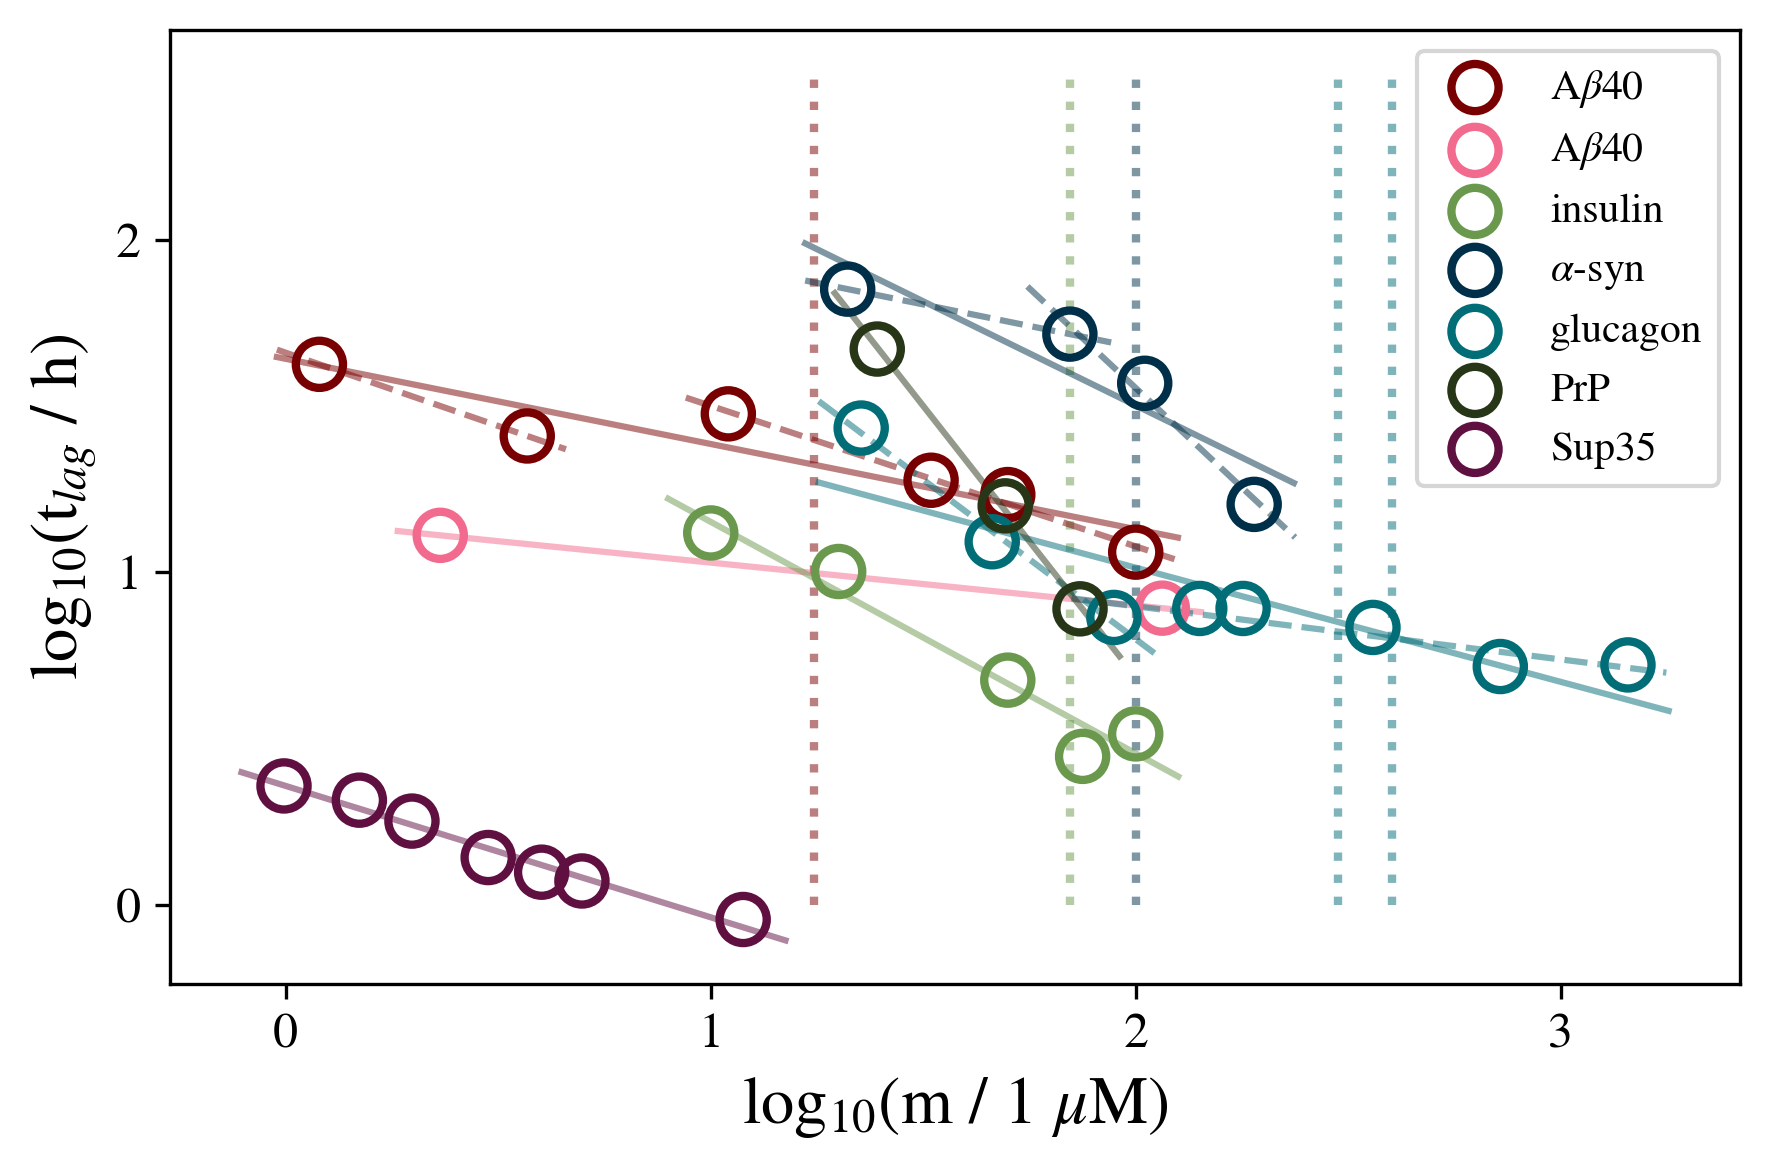

In [371]:
s_dict_elong = {
    1: -0.5,
    2: -1.0,
    3: -1.51,
    4: -2.05,
    5: -2.63,
    6: -3.29
}

s_dict_cap = {
    1: -0.26,
    2: -0.75,
    3: -1.25,
    4: -1.76,
    5: -2.27,
    6: -2.78
}

s_dict_frag = {
    1: -0.18,
    2: -0.39,
    3: -0.66,
    4: -0.99,
    5: -1.42,
    6: -1.97
}


def build_peptide(m_list, t_lag_list, label, color, split=None):
    if regime == "log log":
        ln_m_arr = np.log(np.array(m_list)) / np.log(10)
        ln_t_lag_arr = np.log(np.array(t_lag_list)) / np.log(10)
    elif regime == "frag":
        ln_m_arr = np.log(np.array(m_list) * 10**(-6)) / np.log(10)
        ln_t_lag_arr = np.array(t_lag_list) * 60 * 60 * np.sqrt(np.array(m_list) * 10**(-6))
    elif regime == "eros":
        ln_m_arr = np.log(np.array(m_list))# / np.log(10)
        ln_t_lag_arr = np.array(t_lag_list)

    regr = stats.linregress(ln_m_arr, ln_t_lag_arr)
    print("### PEPTIDE ###")
    print(label)
    print("###############")
    slope, intercept = regr.slope, regr.intercept

    if split is not None:
        m_1_sub, m_2_sub, m_1_sup, m_2_sup = \
            split[0][0]-1, split[0][1], split[1][0]-1, split[1][1]
        regr_sub = stats.linregress(ln_m_arr[m_1_sub:m_2_sub],
                                    ln_t_lag_arr[m_1_sub:m_2_sub])
        slope_sub = regr_sub.slope
        regr_sup = stats.linregress(ln_m_arr[m_1_sup:m_2_sup],
                                    ln_t_lag_arr[m_1_sup:m_2_sup])
        slope_sup = regr_sup.slope

        print("R^2_1", round(regr_sub.rvalue**2, 2))
        print("slope_1", round(slope_sub, 2), "\n   ",
              "N_tan_1", round(get_N_tan(slope_sub), 2), "\n   ",
              "N_elong_1", round(get_N_elong_cap(slope_sub, 1), 2), "\n   ",
              "N_cap_1", round(get_N_elong_cap(slope_sub, 2), 2), "\n   ",
              "N_frag_1", round(get_N_inter(slope_sub, s_dict_frag), 2))

        print("R^2_2", round(regr_sup.rvalue**2, 2))
        print("slope_2", round(slope_sup, 2), "\n   ",
              "N_tan_2", round(get_N_tan(slope_sup), 2), "\n   ",
              "N_elong_2", round(get_N_elong_cap(slope_sup, 1), 2), "\n   ",
              "N_cap_2", round(get_N_elong_cap(slope_sup, 2), 2), "\n   ",
              "N_frag_2", round(get_N_inter(slope_sup, s_dict_frag), 2))

        ln_m_regr_list, ln_t_lag_regr_list = [], []

        ln_m_regr_arr = np.arange(np.min(ln_m_arr[m_1_sub:m_2_sub])-0.1,
                                  np.max(ln_m_arr[m_1_sub:m_2_sub])+0.1,
                                  0.01)
        ln_t_lag_regr_arr = regr_sub.intercept + slope_sub * ln_m_regr_arr

        plot.plot(ln_m_regr_arr, ln_t_lag_regr_arr,
                  color=color, alpha=0.5, zorder=-1, linestyle="--")

        ln_m_regr_list, ln_t_lag_regr_list = [], []

        ln_m_regr_arr = np.arange(np.min(ln_m_arr[m_1_sup:m_2_sup])-0.1,
                                  np.max(ln_m_arr[m_1_sup:m_2_sup])+0.1,
                                  0.01)
        ln_t_lag_regr_arr = regr_sup.intercept + slope_sup * ln_m_regr_arr

        plot.plot(ln_m_regr_arr, ln_t_lag_regr_arr,
                  color=color, alpha=0.5, zorder=-1, linestyle="--")

    ln_m_regr_list, ln_t_lag_regr_list = [], []

    ln_m_regr_arr = np.arange(np.min(ln_m_arr)-0.1, np.max(ln_m_arr)+0.1, 0.01)
    ln_t_lag_regr_arr = intercept + slope * ln_m_regr_arr

    plot.plot(ln_m_regr_arr, ln_t_lag_regr_arr,
              color=color, alpha=0.5, zorder=-1)

    plot.scatter(ln_m_arr, ln_t_lag_arr, s=128, color="none",
                 linewidth=2, edgecolor=color, zorder=0, label=label)

    print("slope log log", round(slope, 2), "\n   ",
          "R^2 log log", round(regr.rvalue**2, 2), "\n   ",
          "N_tan", round(get_N_tan(slope), 2), "\n   ",
          "N_elong", round(get_N_elong_cap(slope, 1), 2), "\n   ",
          "N_cap", round(get_N_elong_cap(slope, 2), 2), "\n   ",
          "N_frag", round(get_N_inter(slope, s_dict_frag), 2), "\n   ",
          "slope_eros", "\n   ",
          "R^2 eros", "\n   ",
          "slope_frag", "\n   ",
          "R^2 frag", "\n   ")        
    print()


fig, ax = plot.subplots()
data_file = open("res/data.txt", "w")

regime = "log log"
#regime = "frag"
#regime = "eros"

# 2014 Alzheimer prot mut / benilova2014alzheimer
amyl_beta_m_list = [100, 50, 33, 11, 3.7, 1.2]
amyl_beta_m_list.reverse()
amyl_beta_t_list = [11.49606, 17.12454, 18.90861, 29.94412, 25.69273, 42.18861]
amyl_beta_t_list.reverse()

data_file.write("amyloid beta 40\n")
for i in range(len(amyl_beta_m_list)):
    data_file.write(str(amyl_beta_m_list[i]) + " " + str(amyl_beta_t_list[i]) + "\n")

build_peptide(amyl_beta_m_list, amyl_beta_t_list,
              r"A$\beta$40", "#780000",
              split=((1, 2), (3, 6)))

plot.vlines(x=np.log(17.5) / np.log(10), ymin=0, ymax=2.5, linestyle="dotted",
            zorder=-2, linewidth=2, color="#780000", alpha=0.5)

# 2005 stock nucl / hortschansky2005aggregation
amyl_beta_m_list = [0.01, 0.5]
amyl_beta_t_list = [12.914842332448384, 7.80115902398663]

data_file.write("amyloid beta 40\n")
for i in range(len(amyl_beta_m_list)):
    data_file.write(str(amyl_beta_m_list[i]) + " " + str(amyl_beta_t_list[i]) + "\n")

build_peptide(np.array(amyl_beta_m_list) * 10**6 / 4330,
              amyl_beta_t_list,
              r"A$\beta$40", "#f26a8d")

# 2017 insulin low mol weight / mawhinney2017elucidation
insulin_m_list = [10, 20, 50, 75, 100]
insulin_t_list = [13.12983, 10.05408, 4.73856, 2.79601, 3.26629]

data_file.write("insulin\n")
for i in range(len(insulin_m_list)):
    data_file.write(str(insulin_m_list[i]) + " " + str(insulin_t_list[i]) + "\n")

build_peptide(insulin_m_list, insulin_t_list,
              "insulin", "#6a994e")

plot.vlines(x=np.log(70) / np.log(10), ymin=0, ymax=2.5, linestyle="dotted",
            zorder=-2, linewidth=2, color="#6a994e", alpha=0.5)

# 2001 aggr / uversky2001metal
alpha_syn_m_list = [190, 105, 70, 21]
alpha_syn_m_list.reverse()
#alpha_syn_t_list = [21.26436, 45.60487, 86.95666, 119.38926]
alpha_syn_t_list = [71, 52, 37, 16]
#alpha_syn_t_list.reverse()

data_file.write("alpha-synuclein\n")
for i in range(len(alpha_syn_m_list)):
    data_file.write(str(alpha_syn_m_list[i]) + " " + str(alpha_syn_t_list[i]) + "\n")

build_peptide(alpha_syn_m_list, alpha_syn_t_list,
              r"$\alpha$-syn", "#003049",
              ((1, 2), (2, 4)))

plot.vlines(x=np.log(100) / np.log(10), ymin=0, ymax=2.5, linestyle="dotted",
            zorder=-2, linewidth=2, color="#003049", alpha=0.5)

# 2010 amyl glucagon fibr / pedersen2010nature
glucagon_m_list = [0.07885698277362686, 0.16038834323050954, 0.3101510016911516, 0.4937606601091607, 0.6244037279870213, 1.2621129501461767, 5.02475666835675, 2.516166466611133]
glucagon_t_list = [27.140770209207215, 12.352425242410687, 7.315527254738861, 7.784049571140164, 7.784049571140164, 6.825437596331329, 5.266058793357991,  5.207599061432788]

data_file.write("glucagon\n")
for i in range(len(glucagon_m_list)):
    data_file.write(str(glucagon_m_list[i]) + " " + str(glucagon_t_list[i]) + "\n")

build_peptide(np.array(glucagon_m_list) * 10**6 / 3490,
              glucagon_t_list,
              "glucagon", "#006d77",
              split=((1,3),(3,8)))

# 2011 dynamic mult struc / alvarez2011dynamics
PrP_m_list = [0.4, 0.8, 1.2]
PrP_t_list = [46.894409937888206, 15.838509316770185, 7.763975155279496]

data_file.write("PrP\n")
for i in range(len(PrP_m_list)):
    data_file.write(str(PrP_m_list[i]) + " " + str(PrP_t_list[i]) + "\n")

build_peptide(np.array(PrP_m_list) / 16227 * 10**6,
              PrP_t_list,
              "PrP", "#283618")

# 2004 Sup35 / collins2004mechanism
Sup35_m_list = [0.9905497407751119, 1.4900329635645067, 1.9811037337930752, 2.994254147511826, 4.0000171712625425, 4.976307588327792, 11.92034046584007]
Sup35_t_list = [136.7119931021745, 123.88085108976797, 107.16659295874662, 83.2790087872571, 75.2444059529987, 70.80067856843452, 54.227435693730705]

data_file.write("Sup35\n")
for i in range(len(Sup35_m_list)):
    data_file.write(str(Sup35_m_list[i]) + " " + str(Sup35_t_list[i]) + "\n")

build_peptide(Sup35_m_list,
              np.array(Sup35_t_list) / 60,
              "Sup35", "#5f0f40")

plot.vlines(x=np.log(300) / np.log(10), ymin=0, ymax=2.5, linestyle="dotted",
            zorder=-2, linewidth=2, color="#006d77", alpha=0.5)
plot.vlines(x=np.log(400) / np.log(10), ymin=0, ymax=2.5, linestyle="dotted",
            zorder=-2, linewidth=2, color="#006d77", alpha=0.5)

plot.xlabel(r"log$_{10}$(m / 1 $\mu$M)", fontsize=16)
plot.ylabel(r"log$_{10}$(t$_{lag}$ / h)", fontsize=16)
plot.xticks(fontsize=12)
plot.yticks(fontsize=12)
plot.locator_params(axis="x", nbins=4)
plot.locator_params(axis="y", nbins=5)
plot.legend()
plot.tight_layout()
plot.savefig("fig/m_t_lag.png")

data_file.close()

# Extracting structural properties of the peptides

In [372]:
names = ["1aml", "3i40", "1xq8", "1gcn", "6du9", "fold_prion", "Sup35"]

for name in names:
    f = open("struc/" + name + ".dssp")
    lines = f.readlines()
    f.close()

    flag = False
    cnt, cnt_hel = 0, 0

    for line in lines:
        tokens = line.split()

        if flag:
            if tokens[1] not in ["!", "!*"]:
                cnt += 1
            if tokens[4] in ["H", "G", "I", "P"]:
                cnt_hel += 1

        if tokens[0] == "#":
            flag = True

    print(name, cnt, cnt_hel, round(cnt_hel / cnt * 100))

1aml 40 15 38
3i40 51 25 49
1xq8 140 83 59
1gcn 29 14 48
6du9 91 55 60
fold_prion 141 67 48
Sup35 254 26 10


# Graphical representation of properties

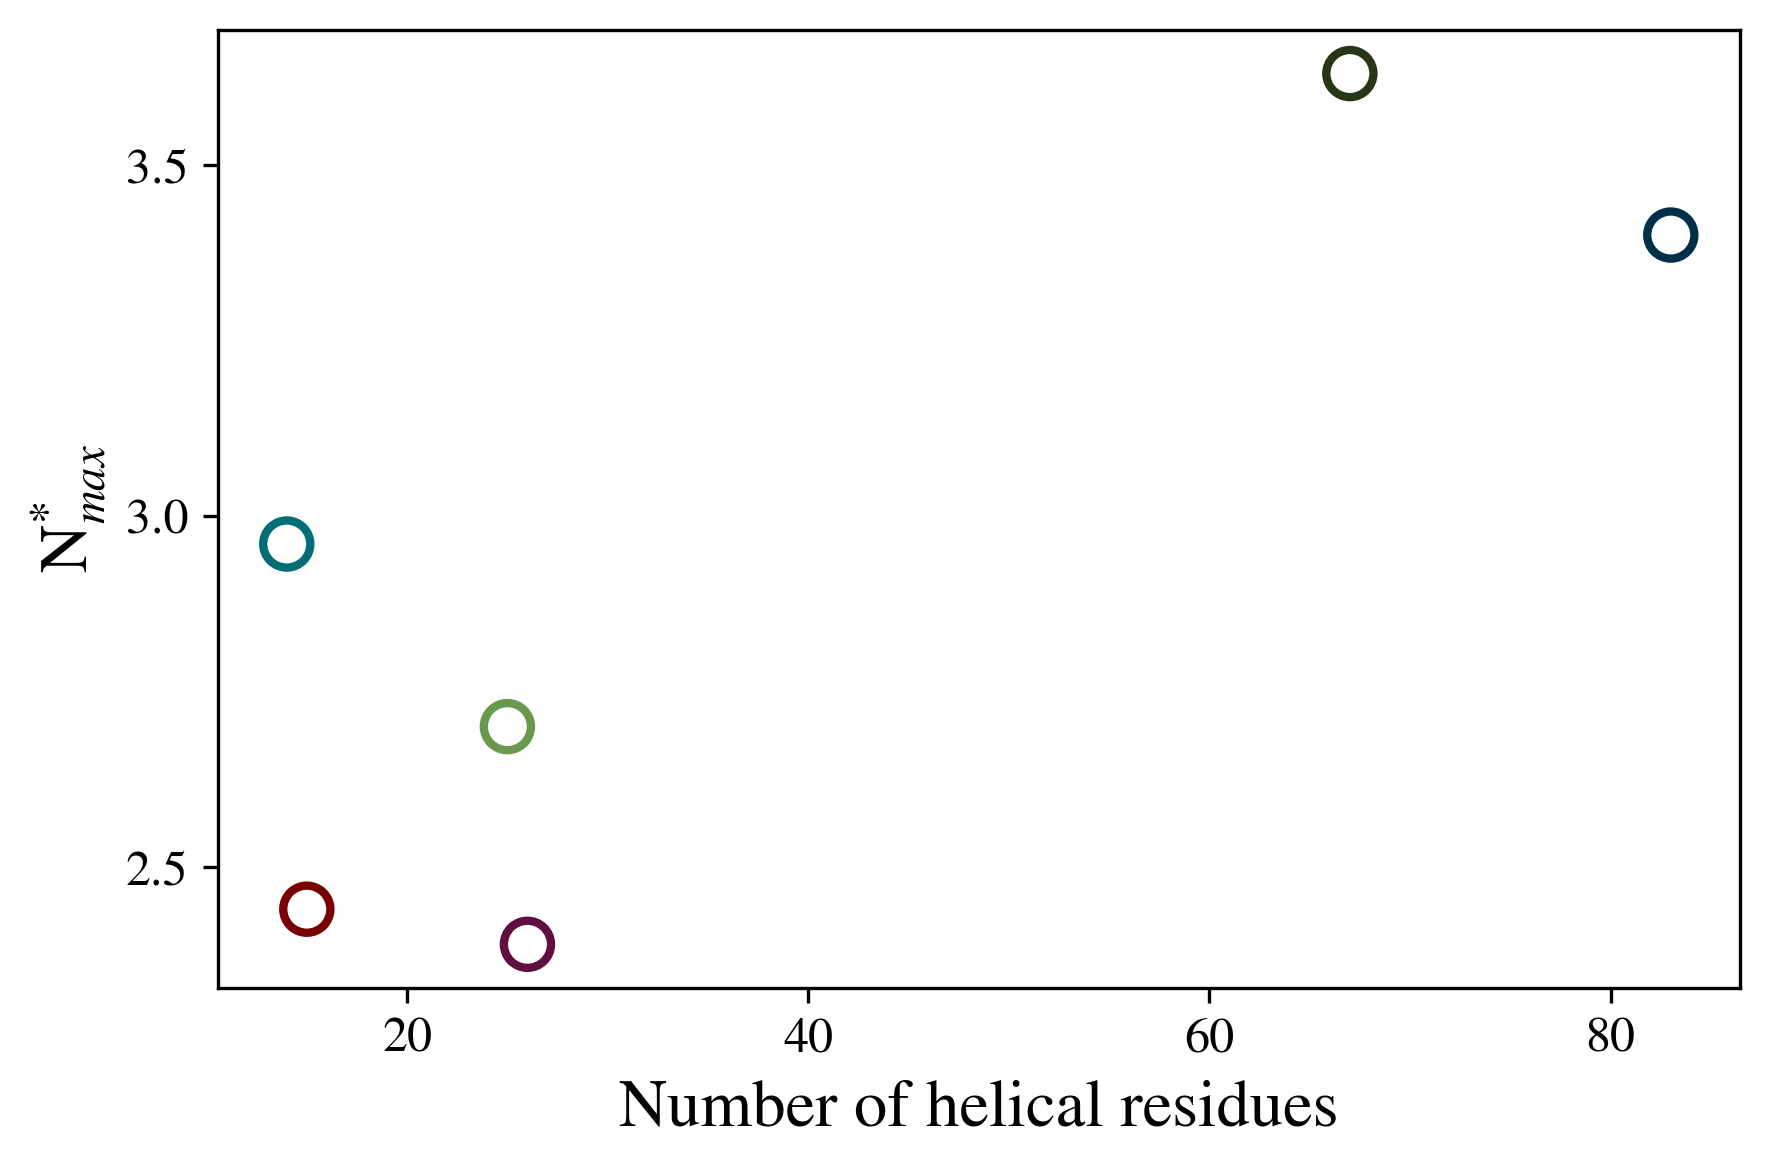

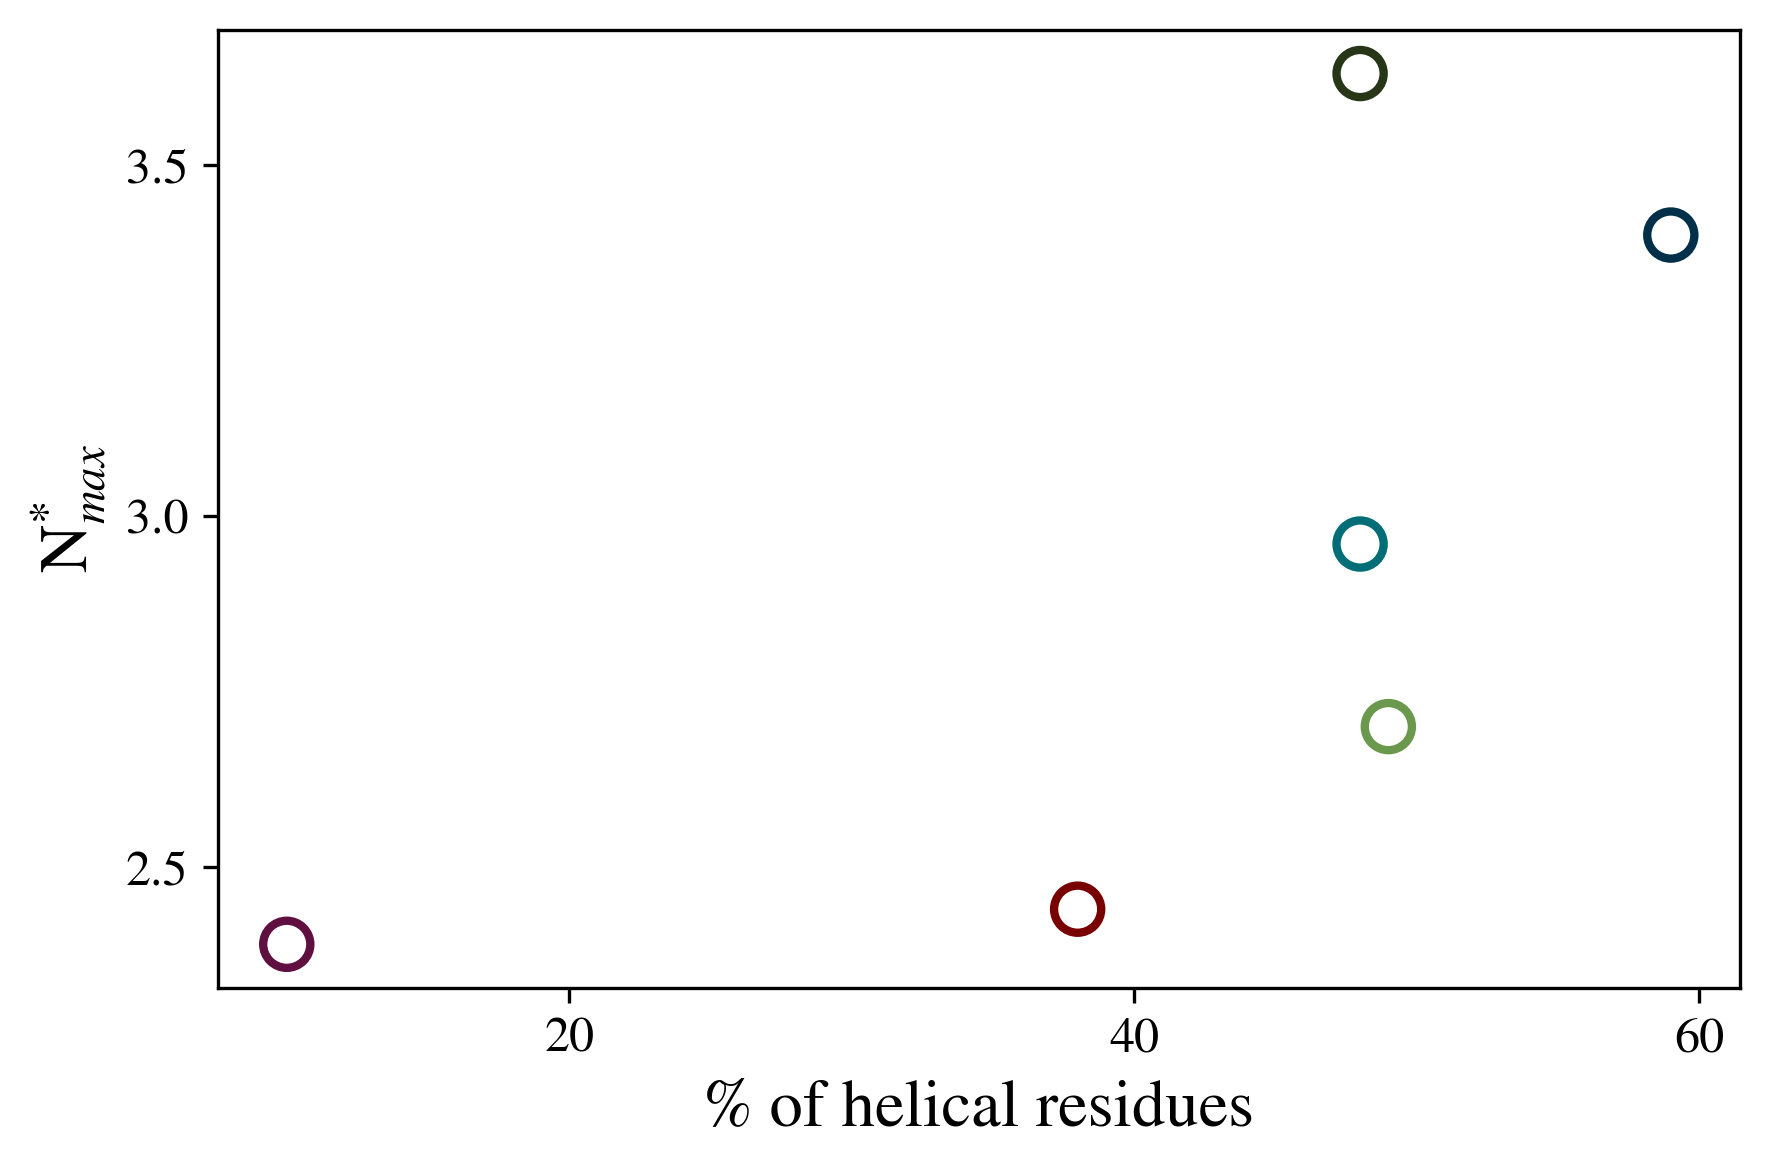

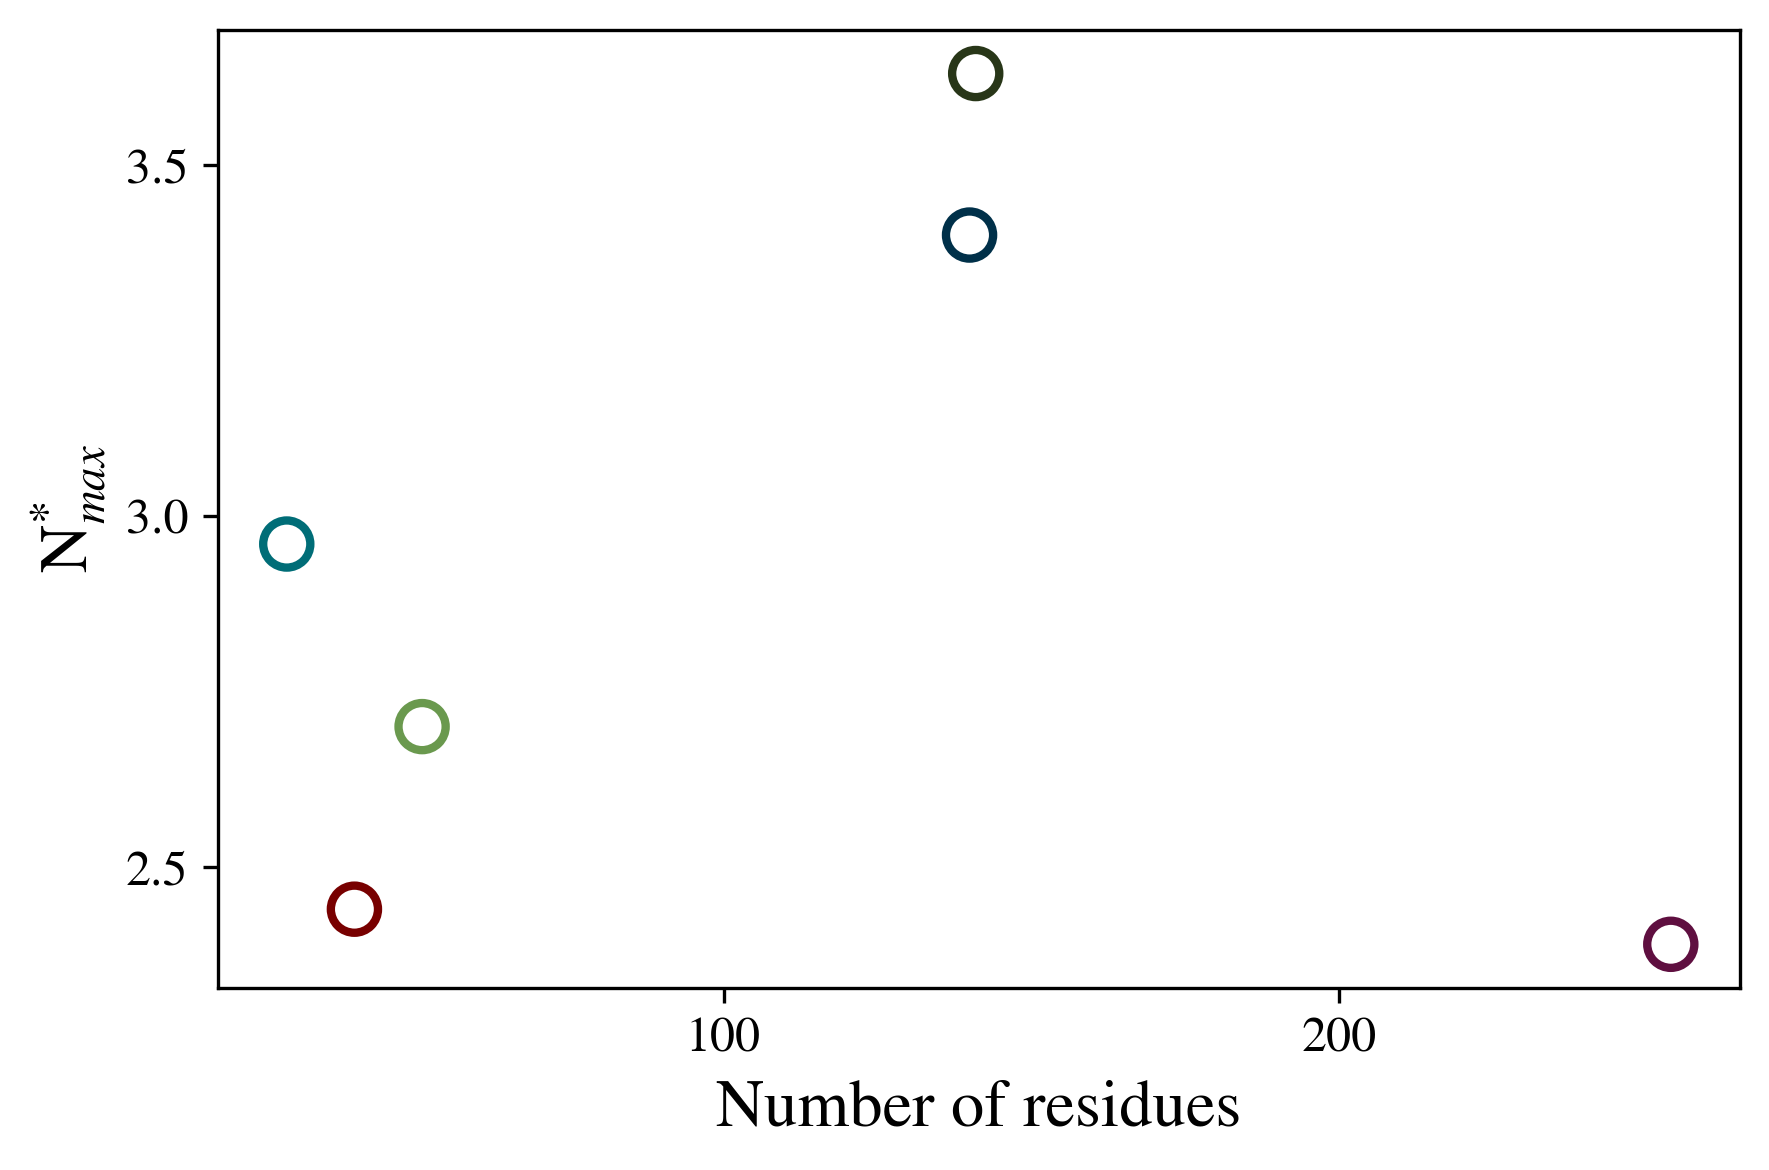

In [373]:
len_cnt = [40, 51, 140, 29, 141, 254]
hel_cnt = [15, 25, 83, 14, 67, 26]
hel_fra = [38, 49, 59, 48, 48, 10]
max_nuc = [2.44, 2.70, 3.4, 2.96, 3.63, 2.39]
colors = ["#780000", "#6a994e", "#003049", "#006d77", "#283618", "#5f0f40"]

plot.scatter(hel_cnt, max_nuc, s=128, color="none",
             linewidth=2, edgecolor=colors, zorder=0,)
plot.xlabel("Number of helical residues", fontsize=16)
plot.ylabel(r"N$^{*}_{max}$", fontsize=16)
plot.xticks(fontsize=12)
plot.yticks(fontsize=12)
plot.locator_params(axis="x", nbins=4)
plot.locator_params(axis="y", nbins=5)
plot.tight_layout()
plot.show()

plot.scatter(hel_fra, max_nuc, s=128, color="none",
             linewidth=2, edgecolor=colors, zorder=0,)
plot.xlabel("% of helical residues", fontsize=16)
plot.ylabel(r"N$^{*}_{max}$", fontsize=16)
plot.xticks(fontsize=12)
plot.yticks(fontsize=12)
plot.locator_params(axis="x", nbins=4)
plot.locator_params(axis="y", nbins=5)
plot.tight_layout()
plot.show()

plot.scatter(len_cnt, max_nuc, s=128, color="none",
             linewidth=2, edgecolor=colors, zorder=0,)
plot.xlabel("Number of residues", fontsize=16)
plot.ylabel(r"N$^{*}_{max}$", fontsize=16)
plot.xticks(fontsize=12)
plot.yticks(fontsize=12)
plot.locator_params(axis="x", nbins=4)
plot.locator_params(axis="y", nbins=5)
plot.tight_layout()
plot.show()

In [374]:
# alpha syn
m_arr = np.array([21, 70, 105, 190])
t_05_arr = np.array([71, 52, 37, 16])
ln_m_arr = ln(m_arr)
ln_t_05_arr = ln(t_05_arr)
slope = stats.linregress(ln_m_arr, ln_t_05_arr).slope
print("log log slope", slope)
print("frag coord slope", get_frag_slope(m_arr, t_05_arr))
plot.scatter(ln_m_arr, ln_t_05_arr)
plot.show()
# insulin

log log slope -0.6264828567794891


TypeError: get_frag_slope() missing 1 required positional argument: 'N'

# (C) Egor Vasilenko, Dmitry Ivankov, 2025